# Projet Mécanique des Fluides : Projet 4


In [28]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from numba import jit   
import time 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import copy

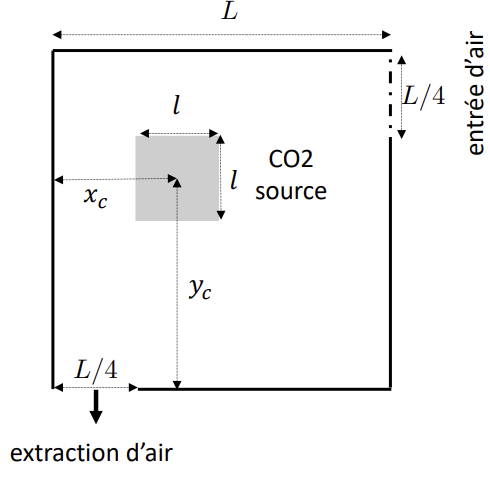


In [29]:
# ======= Problem parameters =================
CO2_LIMIT = 0.001 
time_interval = 24.0 #hrs
rho = 1.2             # density (kg/m^3) - incompressible baseline
nu = 15.6 * 1e-6             # kinematic viscosity (m^2/s)
D_co2 = nu         # molecular diffusivity for CO2 in air (m^2/s)

# ======= Domain parameters =================
L = 5.0            # length of the domain
h = 2.5 # height
yinj = 7*L/8  # inlet vertical location
linj = L / 4.0  # inlet vertical length

# Inlet velocity profile function
def u_inlet(y, Q):
    term = (y - (yinj - linj / 2)) / linj
    return -6 * Q / (linj * h) * term * (1 - term)

# ====== Time-stepping parameters ==================
t = time_interval  * 3600.0  # total time in seconds
Fo = 0.2
CFL = 0.25

# ======== Scalar Concentration field parameters =================
S0 = 3e-7  # s^-1 - source strength
xc = L * 3/8
yc = L * 5/8  
l_source = 1 # m

INLET_CO2 = 0.0004     # molar fraction at inlet (Dirichlet on inlet segment)
INIT_CO2 = 0.0004    # initial concentration in domain


La Vitesse imposée selon un profil parabolique au niveau de l'entrée d'air, d'équation :

$$
u(t,y) = -6\,\frac{Q}{l_{\text{inj}}\,h}\,
\left(
  \frac{y - \bigl(y_{\text{inj}} - l_{\text{inj}}/2\bigr)}{l_{\text{inj}}}
\right)
\left(
  1 - \frac{y - \bigl(y_{\text{inj}} - l_{\text{inj}}/2\bigr)}{l_{\text{inj}}}
\right).
$$


In [30]:
def compute_source_term(c, S, x_source_start, x_source_end, y_source_start, y_source_end):
    S[x_source_start:x_source_end+1, y_source_start:y_source_end+1] = S0 * (1 - c[x_source_start:x_source_end+1, y_source_start:y_source_end+1])
    return S


### Boundary conditions for the scalar field and for the velocity field

The scalar field satisfies homogeneous Neumann conditions on the solid walls:
$$
\begin{aligned}
\frac{\partial c}{\partial n} = 0
\qquad \text{on }
\begin{cases}
y = 0,\; y=L, \\
x = 0, \\
x = L,\; y < y_{\text{inlet}},
\end{cases}
\end{aligned}$$
and a Dirichlet condition on the inlet segment:
$$
\begin{aligned}
c(x=L, y) = c_{\text{inlet}}
\qquad \text{for } y \ge y_{\text{inlet}}.
\end{aligned}$$

The no-slip condition is imposed on all solid walls:
$$
\begin{aligned}
\mathbf{u} = (u,v) = \mathbf{0}
\qquad \text{on }
\begin{cases}
y = L, \\
x = 0, \\
x = L,\; y < y_{\text{inlet}},
\end{cases}
\end{aligned}$$

A natural outlet condition is applied at the bottom opening:
$$
\begin{aligned}
\frac{\partial \mathbf{u}}{\partial n} = 0
\qquad \text{for } y = 0,\; x \le x_{\text{outlet}}.
\end{aligned}$$

A Dirichlet inflow profile is prescribed at the inlet:
$$
\begin{aligned}
u(x=L,y) = u_{\text{inlet}}(y), 
\qquad v(x=L,y)=0,
\qquad \text{for } y \ge y_{\text{inlet}}.
\end{aligned}$$


In [31]:
# ---- Scalar boundary conditions (Accepts Indices) ----
def apply_scalar_bcs(c, y_inlet_idx, inlet_val):    
    """
    Enforce:
      - zero normal gradient (Neumann) on all walls
      - Dirichlet c = INLET_CO2 on inlet region: right boundary for j >= y_inlet_index
    """
    c[:, 0] = c[:, 1]       # Bottom
    c[:, -1] = c[:, -2]     # Top
    c[0, :] = c[1, :]       # Left
    
    c[-1, :y_inlet_idx] = c[-2, :y_inlet_idx] # Right Wall
    c[-1, y_inlet_idx:] = inlet_val           # Right Inlet
    return c


# --- Updated BC Function (Accepts indices as arguments) ---
def apply_velocity_bcs(u, v, x_extract_idx, y_inlet_idx, u_inlet_arr):
    """
    Applies BCs using dynamic indices calculated for the specific mesh size.
    u_inlet_arr: Pre-calculated array of inlet velocities to avoid re-computing
    """    
    # Bottom wall (y=0)
    # 1. Left of outlet
    u[:x_extract_idx+1, 0] = u[:x_extract_idx+1, 1]
    v[:x_extract_idx+1, 0] = v[:x_extract_idx+1, 1]
    #p[:x_extract_idx+1, 0] = 0.0 # Outlet pressure anchor
    
    # 2. Right of outlet (solid wall)
    u[x_extract_idx+1:, 0] = 0.0
    v[x_extract_idx+1:, 0] = 0.0
    #p[x_extract_idx+1:, 0] = p[x_extract_idx+1:, 1]

    # Top wall (y=L)
    u[:, -1] = 0.0
    v[:, -1] = 0.0
    #p[:, -1] = p[:, -2]

    # Left wall (x=0)
    u[0, :] = 0.0
    v[0, :] = 0.0
    #p[0, :] = p[1, :]

    # Right wall (x=L)
    #p[-1, :] = p[-2, :] # Zero gradient pressure
    
    # 1. Below inlet (Solid wall)
    u[-1, :y_inlet_idx] = 0.0
    v[-1, :] = 0.0 
    
    # 2. At Inlet (Dirichlet)
    # We assign the pre-calculated inlet profile
    # Ensure sizes match: u_inlet_arr should be length (Ny - y_inlet_idx)
    u[-1, y_inlet_idx:] = u_inlet_arr
    
    return u, v


### Pressure boundary conditions

The pressure field satisfies a Dirichlet condition at the outlet and homogeneous
Neumann conditions on all solid walls.

At the bottom-left outlet:
$$
\begin{aligned}
p(x,0) &= 0
\qquad \text{for } x \le x_{\text{outlet}} .
\end{aligned}
$$

On the remaining part of the bottom boundary (solid wall):
$$
\begin{aligned}
\frac{\partial p}{\partial y}(x,0) &= 0
\qquad \text{for } x > x_{\text{outlet}} .
\end{aligned}
$$

On the top boundary:
$$
\begin{aligned}
\frac{\partial p}{\partial y}(x,L) &= 0 .
\end{aligned}
$$

On the left boundary:
$$
\begin{aligned}
\frac{\partial p}{\partial x}(0,y) &= 0 .
\end{aligned}
$$

On the right boundary:
$$
\begin{aligned}
\frac{\partial p}{\partial x}(L,y) &= 0 .
\end{aligned}
$$

A homogeneous Neumann condition is implemented numerically by copying the
adjacent interior value:
$$
\begin{aligned}
p_{\text{wall}} = p_{\text{interior}}
\quad \Longleftrightarrow \quad
\frac{\partial p}{\partial n} = 0 .
\end{aligned}
$$


In [32]:
# --- Updated BC Function (Accepts indices as arguments) ---
def apply_pressure_bcs(p, x_extract_idx):
    
    # Bottom wall (y=0)
    # 1. Left of outlet
    p[:x_extract_idx+1, 0] = 0.0 # Outlet pressure 
    # 2. Right of outlet (solid wall)
    p[x_extract_idx+1:, 0] = p[x_extract_idx+1:, 1]

    # Top wall (y=L)
    p[:, -1] = p[:, -2]

    # Left wall (x=0)
    p[0, :] = p[1, :]

    # Right wall (x=L)
    p[-1, :] = p[-2, :] # Zero gradient pressure
    
    return p

@jit(nopython=True)
def apply_pressure_bcs_loop(p, x_extract_idx):

    nx, ny = p.shape  # grid dimensions

    # --- Bottom wall (y = 0) ---
    # 1. Left of outlet
    for i in range(0, x_extract_idx + 1):
        p[i, 0] = 0.0

    # 2. Right of outlet (solid wall)
    for i in range(x_extract_idx + 1, nx):
        p[i, 0] = p[i, 1]

    # --- Top wall (y = L) ---
    for i in range(nx):
        p[i, ny - 1] = p[i, ny - 2]

    # --- Left wall (x = 0) ---
    for j in range(ny):
        p[0, j] = p[1, j]

    # --- Right wall (x = L) ---
    for j in range(ny):
        p[nx - 1, j] = p[nx - 2, j]

    return p

### Advection step (upwind scheme)

We recall that the advection of a generic velocity component $\phi \in \{u,v\}$ 
is governed by the nonlinear transport equation
$$
\frac{\partial \phi}{\partial t}
+ u\,\frac{\partial \phi}{\partial x}
+ v\,\frac{\partial \phi}{\partial y}
= 0 .
$$


The updated value of \(u\) is then obtained from the discrete advection equation:
$$
u_{i,j}^{\,n+1}
=
u_{i,j}^{\,n}
-
\Delta t
\left(
u_{i,j}^{\,n} \frac{\partial u}{\partial x}\Big|_{i,j}
+
v_{i,j}^{\,n} \frac{\partial u}{\partial y}\Big|_{i,j}
\right).
$$

The same upwind logic is applied to advect the vertical velocity component \(v\):
$$
v_{i,j}^{\,n+1}
=
v_{i,j}^{\,n}
-
\Delta t
\left(
u_{i,j}^{\,n} \frac{\partial v}{\partial x}\Big|_{i,j}
+
v_{i,j}^{\,n} \frac{\partial v}{\partial y}\Big|_{i,j}
\right).
$$

This corresponds exactly to the implementation of the advect(u, v, dx, dy, dt) function, where the direction of the
upwind stencil is chosen based on the sign of the local velocity.


In [33]:

@jit(nopython=True)
def advect(u, v, dx, dy, dt):
    Nx, Ny = u.shape
    u_new = np.copy(u)
    v_new = np.copy(v)
    
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            # simple upwind for u
            if u[i,j] > 0:
                du_dx = (u[i,j] - u[i-1,j]) / dx
            else:
                du_dx = (u[i+1,j] - u[i,j]) / dx

            if v[i,j] > 0:
                du_dy = (u[i,j] - u[i,j-1]) / dy
            else:
                du_dy = (u[i,j+1] - u[i,j]) / dy

            # could calculate this using derivative squared velocity, as per formula , but this should work too
            u_new[i,j] = u[i,j] - dt * (u[i,j]*du_dx + v[i,j]*du_dy) 

            # same for v
            if u[i,j] > 0:
                dv_dx = (v[i,j] - v[i-1,j]) / dx
            else:
                dv_dx = (v[i+1,j] - v[i,j]) / dx

            if v[i,j] > 0:
                dv_dy = (v[i,j] - v[i,j-1]) / dy
            else:
                dv_dy = (v[i,j+1] - v[i,j]) / dy

            v_new[i,j] = v[i,j] - dt * (u[i,j]*dv_dx + v[i,j]*dv_dy)
    
    return u_new, v_new

### Diffusion step (viscous term)

The diffusion of the velocity components is governed by the viscous term of the
Navier--Stokes equations:
$$
\frac{\partial \mathbf{u}}{\partial t}
= 
\nu \, \nabla^2 \mathbf{u},
\qquad 
\mathbf{u} = (u,v).
$$

For each component, the Laplacian on a uniform Cartesian grid is discretized
using second-order central differences:
$$
\begin{aligned}
\nabla^2 u_{i,j}
&=
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^2}
+
\frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{\Delta y^2}, \\[0.8em]
\nabla^2 v_{i,j}
&=
\frac{v_{i+1,j} - 2v_{i,j} + v_{i-1,j}}{\Delta x^2}
+
\frac{v_{i,j+1} - 2v_{i,j} + v_{i,j-1}}{\Delta y^2}.
\end{aligned}
$$

Using an explicit time integration, the updated velocities are computed as:
$$
\begin{aligned}
u_{i,j}^{\,n+1}
&=
u_{i,j}^{\,n}
+
\Delta t \, \nu 
\left( \nabla^2 u_{i,j}^{\,n} \right), \\[0.5em]
v_{i,j}^{\,n+1}
&=
v_{i,j}^{\,n}
+
\Delta t \, \nu 
\left( \nabla^2 v_{i,j}^{\,n} \right).
\end{aligned}
$$

This corresponds exactly to the implementation of the function
\texttt{diffuse(u, v, dx, dy, dt, nu)}, where the Laplacian is computed with
central differences and the velocity is advanced explicitly.


In [34]:
@jit(nopython=True)
def diffuse(u, v, dx, dy, dt, nu):
    Nx, Ny = u.shape
    u_new = np.copy(u)
    v_new = np.copy(v)

    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            u_lap = (u[i+1,j] - 2*u[i,j] + u[i-1,j]) / dx**2 + \
                    (u[i,j+1] - 2*u[i,j] + u[i,j-1]) / dy**2
            v_lap = (v[i+1,j] - 2*v[i,j] + v[i-1,j]) / dx**2 + \
                    (v[i,j+1] - 2*v[i,j] + v[i,j-1]) / dy**2

            u_new[i,j] = u[i,j] + dt * nu * u_lap
            v_new[i,j] = v[i,j] + dt * nu * v_lap

    return u_new, v_new


### Pressure projection (Poisson solver + velocity correction)

To enforce incompressibility, the intermediate velocity field 
$u^{*}, v^{*}$ obtained after advection and diffusion must satisfy:
$$
\nabla \cdot \mathbf{u}^{\,n+1} = 0 .
$$

We introduce a pressure field that projects the intermediate velocity
onto a divergence-free state:
$$
u^{n+1} = u^{*} - \frac{\Delta t}{\rho} \, \frac{\partial p}{\partial x},
\qquad
v^{n+1} = v^{*} - \frac{\Delta t}{\rho} \, \frac{\partial p}{\partial y}.
$$

Taking the divergence and using $\nabla \cdot \mathbf{u}^{\,n+1} = 0$ gives the Poisson equation:
$$
\nabla^{2} p
=
\frac{\rho}{\Delta t}
\left(
\frac{\partial u^{*}}{\partial x}
+
\frac{\partial v^{*}}{\partial y}
\right).
$$

On a uniform Cartesian grid, the Laplacian is approximated by:
$$
\nabla^{2} p_{i,j}
=
\frac{p_{i+1,j} - 2 p_{i,j} + p_{i-1,j}}{\Delta x^{2}}
+
\frac{p_{i,j+1} - 2 p_{i,j} + p_{i,j-1}}{\Delta y^{2}}.
$$

We solve this equation using a Jacobi iteration:
$$
p_{i,j}^{(k+1)}
=
\frac{
\left(p_{i+1,j}^{(k)} + p_{i-1,j}^{(k)}\right)\Delta y^{2}
+
\left(p_{i,j+1}^{(k)} + p_{i,j-1}^{(k)}\right)\Delta x^{2}
-
b_{i,j}\,\Delta x^{2}\Delta y^{2}
}{
2(\Delta x^{2} + \Delta y^{2})
}.
$$

Once the pressure is converged, the corrected velocity is:
$$
u_{i,j}^{\,n+1}
=
u_{i,j}^{*}
-
\frac{\Delta t}{\rho}
\frac{p_{i+1,j} - p_{i-1,j}}{2\Delta x},
$$
$$
v_{i,j}^{\,n+1}
=
v_{i,j}^{*}
-
\frac{\Delta t}{\rho}
\frac{p_{i,j+1} - p_{i,j-1}}{2\Delta y}.
$$

This enforces the divergence-free condition at each time step and matches
the implementation is the functions pressure_projection_absolute and 
pressure_projection.


In [35]:

@jit(nopython=True)
def pressure_projection_absolute(u, v, p, dx, dy, dt, rho, max_iter=500, tol=1e-6):
    Nx, Ny = u.shape
    b = np.zeros_like(p)
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            b[i,j] = rho/dt * ((u[i+1,j]-u[i-1,j])/(2*dx) + 
                                (v[i,j+1]-v[i,j-1])/(2*dy))
    
    pn = np.copy(p)
    for it in range(max_iter):
        p_new = np.copy(pn)
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                p_new[i,j] = ((pn[i+1,j] + pn[i-1,j])*dy**2 + 
                              (pn[i,j+1] + pn[i,j-1])*dx**2 -
                              b[i,j]*dx**2*dy**2) / (2*(dx**2 + dy**2))
        if np.linalg.norm(p_new - pn, ord=np.inf) < tol:
            break
        pn = p_new.copy()
    p[:] = pn
    
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            u[i,j] -= dt/rho * (p[i+1,j]-p[i-1,j])/(2*dx)
            v[i,j] -= dt/rho * (p[i,j+1]-p[i,j-1])/(2*dy)
    
    return u, v, p

@jit(nopython=True)
def pressure_projection(u, v, p, dx, dy, dt, rho, x_extract_index, max_iter=100000, tol=1e-1):
    """
    Solves the pressure Poisson equation using a Jacobi iterative solver.
    Convergence is checked using the L2 norm of the relative residual:
    ||A*p - b||  < tol * ||b||
    """

    Nx, Ny = u.shape
    b = np.zeros_like(p)
    
    # --- 1. Calculate RHS (b) and its L2 norm (norm_b) ---
    # b[i,j] = (rho/dt) * (divergence of u_intermediate)
    norm_b_sq = 0.0
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            b[i,j] = rho/dt * ((u[i+1,j] - u[i-1,j]) / (2*dx) + 
                                (v[i,j+1] - v[i,j-1]) / (2*dy))
            norm_b_sq += b[i,j]**2
    
    norm_b = np.sqrt(norm_b_sq)
    
    # --- 2. Set the convergence threshold ---
    if norm_b < 1e-12:
        check_tol = tol 
        # If ||b|| is very small (e.g., flow is divergence-free),
        # absolute tolerance to handle precision problems on computer. 
    else:
        check_tol = tol * norm_b

    pn = np.copy(p)
    
    # Pre-calculate constants
    dx2 = dx**2
    dy2 = dy**2
    denominator = 2.0 * (dx2 + dy2)
    
    num_iters = 0 # To track iteration count

    for it in range(max_iter):
        num_iters = it + 1  # Current iteration number
        p_new = np.copy(pn)
        
        # --- 3. Jacobi iteration step ---
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                p_new[i,j] = ((pn[i+1,j] + pn[i-1,j]) * dy2 + 
                              (pn[i,j+1] + pn[i,j-1]) * dx2 -
                              b[i,j] * dx2 * dy2) / denominator
        
        p_new = apply_pressure_bcs_loop(p_new, x_extract_index)

        # --- 4. New convergence check: ||A*p_new - b|| < check_tol ---
        # We must calculate the L2 norm of the residual: r = b - A*p_new
        norm_r_sq = 0.0
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                # Discrete Laplacian: A*p_new[i,j]
                lap_p = (p_new[i+1,j] - 2*p_new[i,j] + p_new[i-1,j]) / dx2 + \
                        (p_new[i,j+1] - 2*p_new[i,j] + p_new[i,j-1]) / dy2
                
                # Residual: r[i,j] = b[i,j] - A*p_new[i,j]
                residual_ij = b[i,j] - lap_p
                
                # Accumulate squared L2 norm
                norm_r_sq += residual_ij**2
                
        norm_r = np.sqrt(norm_r_sq)

        # --- 5. Check for convergence ---
        if norm_r < check_tol:
            pn = p_new.copy()  # Save the converged solution
            break              # Exit iteration loop
            
        pn = p_new.copy()  # Prepare for next iteration 

    p[:] = pn  
    #print(f"Pressure projection converged in {num_iters} iterations.")
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            u[i,j] -= dt/rho * (p[i+1,j]-p[i-1,j])/(2*dx)
            v[i,j] -= dt/rho * (p[i,j+1]-p[i,j-1])/(2*dy)
    
    return u, v, p

### Scalar transport: diffusion and advection

The concentration field $c(x,y,t)$ obeys a standard advection–diffusion
equation:
$$
\frac{\partial c}{\partial t}
=
D \nabla^{2} c
-
\left(
u \frac{\partial c}{\partial x}
+
v \frac{\partial c}{\partial y}
\right).
$$


#### Diffusion (central differences)

The Laplacian is discretized using second–order central differences:
$$
\nabla^{2} c_{i,j}
=
\frac{c_{i+1,j} - 2c_{i,j} + c_{i-1,j}}{\Delta x^{2}}
+
\frac{c_{i,j+1} - 2c_{i,j} + c_{i,j-1}}{\Delta y^{2}}.
$$

The explicit update is:
$$
c_{i,j}^{\,n+1}
=
c_{i,j}^{\,n}
+
\Delta t \, D \, \nabla^{2} c_{i,j}^{\,n}.
$$

This corresponds to the function `diffuse_scalar`.


#### Advection (upwind scheme)


The explicit advection update is:
$$
c_{i,j}^{\,n+1}
=
c_{i,j}^{\,n}
-
\Delta t
\left(
u_{i,j}^{\,n} \frac{\partial c}{\partial x}\Big|_{i,j}
+
v_{i,j}^{\,n} \frac{\partial c}{\partial y}\Big|_{i,j}
\right).
$$



In [36]:

@jit(nopython=True)
def diffuse_scalar(c, dx, dy, dt, D):
    Nx, Ny = c.shape
    c_new = np.copy(c)
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            lap = (c[i+1, j] - 2.0*c[i, j] + c[i-1, j]) / dx**2 + \
                  (c[i, j+1] - 2.0*c[i, j] + c[i, j-1]) / dy**2
            c_new[i, j] = c[i, j] + dt * D * lap
    return c_new

@jit(nopython=True)
def advect_scalar(c, u, v, dx, dy, dt):
    Nx, Ny = c.shape
    c_new = np.copy(c)
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            # upwind derivative in x
            if u[i, j] > 0.0:
                dc_dx = (c[i, j] - c[i-1, j]) / dx
            else:
                dc_dx = (c[i+1, j] - c[i, j]) / dx
            # upwind derivative in y
            if v[i, j] > 0.0:
                dc_dy = (c[i, j] - c[i, j-1]) / dy
            else:
                dc_dy = (c[i, j+1] - c[i, j]) / dy

            c_new[i, j] = c[i, j] - dt * (u[i, j] * dc_dx + v[i, j] * dc_dy)
    return c_new

### Pressure-loss coefficient \(C_p\)

To quantify the global pressure losses in the enclosure, a non-dimensional
pressure-loss coefficient is defined as:
$$
C_p
=
\frac{P_{\text{inlet}} - P_{\text{outlet}}}
{\tfrac{1}{2}\,\rho\,U_{\text{ref}}^{2}}.
$$

Because the outlet boundary condition imposes
$$
P_{\text{outlet}} = 0,
$$
the expression simplifies to:
$$
C_p = 
\frac{P_{\text{inlet}}}
{\tfrac{1}{2}\,\rho\,U_{\text{ref}}^{2}}.
$$

#### Inlet pressure

The inlet static pressure is obtained by averaging the pressure values on the
inlet segment of the right boundary:
$$
P_{\text{inlet}}
=
\frac{1}{N_{\text{inlet}}}
\sum_{j = y_{\text{inlet}}}^{N_y}
p(x=L,\,y_j).
$$

This corresponds to:
- `p[-1, y_inlet_idx:]` in the code  
- `np.mean` to compute the average.

#### Reference velocity

Since the outlet is an open boundary, the reference velocity is taken as the
average vertical velocity along the outlet section:
$$
U_{\text{ref}}
=
\frac{1}{N_{\text{out}}}
\sum_{i=0}^{x_{\text{outlet}}}
v(x_i,\, y=0).
$$

This matches:
- `v[:x_extract_idx+1, 0]` in the code  
- `np.mean(v_out)` for averaging.

#### Dynamic pressure

The reference dynamic pressure is:
$$
q_{\text{ref}}
=
\frac{1}{2}\,\rho\,U_{\text{ref}}^{2}.
$$

#### Final expression

Thus, the code implements:
$$
C_p
=
\frac{P_{\text{inlet}}}{q_{\text{ref}}}.
$$

If $$(U_{\text{ref}} \approx 0)$$, the function returns zero to avoid division by zero.

This corresponds exactly to the implementation of 
`compute_pressure_coefficient(p, u, v, y_inlet_idx, x_extract_idx)`.


In [37]:
def compute_pressure_coefficient(p, u, v, y_inlet_idx, x_extract_idx):
    """
    Computes a single scalar Cp representing the total pressure loss coefficient.
    
    Cp_global = (P_avg_inlet - P_avg_outlet) / (0.5 * rho * U_ref^2)
    
    Since P_outlet is set to 0 in BCs, this simplifies to P_avg_inlet / q_ref.
    """
    
    # Calculate Average Inlet Pressure ---
    p_inlet_vals = p[-1, y_inlet_idx:]
    p_avg_inlet = np.mean(p_inlet_vals)
    
    # Calculate Reference Velocity (U_ref)
    # u_out = u[:x_extract_idx+1, 0]
    v_out = v[:x_extract_idx+1, 0]
    
    # vel_mag_out = np.sqrt(u_out**2 + v_out**2)
    
    # U_ref = np.mean(vel_mag_out)
    U_ref = np.mean(v_out)

    if abs(U_ref) < 1e-9:
        return 0.0  # Avoid division by zero

    # Compute Dynamic Pressure ---
    q_ref = 0.5 * rho * U_ref**2
    
    # Compute Global Cp ---
    # P_outlet is 0.0
    Cp = p_avg_inlet / q_ref
    
    return Cp



#### Velocity and pressure fields

The function `visualize_field(X, Y, u, v, p, ...)` displays the instantaneous
velocity magnitude
$$
|u| = \sqrt{u^2 + v^2}
$$
as a filled contour plot over the domain, using the coordinates \((X,Y)\). Optionally, pressure contours are superimposed when `show_pressure = True`.  

The function `visualize_field_and_co2(ax_vel, ax_co2, X, Y, u, v, c, p, ...)`
produces side-by-side plots: one for the velocity magnitude (with arrows from
`quiver`) and one for the CO\(_2\) concentration field \(c(x,y)\).

#### CO2 scalar visualisation

The function `visualize_CO2(X, Y, c, ...)` shows the scalar field
\(c(x,y)\) as a filled contour plot.

The function `plot_CO2_time_evolution(Xavg, Xmax, dt)` plots the time evolution
of the spatially averaged concentration and the maximum concentration:
$$
X_{\text{avg}}(t_k), \qquad X_{\max}(t_k),
$$
including:
- a horizontal line at the regulatory limit $$X = \text{CO2\_LIMIT}$$,
- a vertical line at $$t = 12\ \text{h}$$ to mark the end of the source period.

Time is converted from seconds to hours using $$ t_k = k\,\Delta t / 3600 $$.

In [38]:

def visualize_field(X, Y, u, v, p=None, step=None, show_pressure=False, time_hours = None, stride=5):
    """
    Visualize the 2D velocity and pressure fields.

    Parameters
    ----------
    X, Y : 2D arrays
        Meshgrid coordinates (from np.meshgrid with indexing='ij')
    u, v : 2D arrays
        Velocity components
    p : 2D array, optional
        Pressure field (if provided)
    step : int, optional
        Time-step number to display in title
    show_pressure : bool
        If True, overlay pressure contours
    stride : int
        Spacing for velocity arrows (higher = fewer arrows)
    """
    plt.clf()
    vel_mag = np.sqrt(u**2 + v**2)

    #plt.figure(figsize=(7, 6))
    plt.contourf(X, Y, vel_mag, levels=50, cmap='viridis')
    plt.colorbar(label='Velocity magnitude |u|')

    # # Overlay velocity vectors
    # plt.quiver(
    #     X[::stride, ::stride],
    #     Y[::stride, ::stride],
    #     u[::stride, ::stride],
    #     v[::stride, ::stride],
    #     color='white',
    # )

    if show_pressure and p is not None:
        plt.contour(X, Y, p, levels=5, colors='k', linewidths=0.8, alpha=0.6)

    plt.xlabel('x')
    plt.ylabel('y')
    title = "Velocity Field"
    if step is not None:
        title += f" at step {step}"
    if time_hours is not None:
        title += f", time {time_hours:.2f} hrs"
    plt.title(title)

def visualize_CO2(X, Y, c, step=None, time_hours=None):

    plt.clf()
    plt.contourf(X, Y, c, levels=50)
    plt.colorbar(label='CO2 scalar (units depend on chosen S_scalar)')

    plt.xlabel('x')
    plt.ylabel('y')
    title = "CO2 Molar Fraction Field"
    if step is not None:
        title += f" at step {step}"
    if time_hours is not None:
        title += f", time {time_hours:.2f} hrs"
    plt.title(title)


def visualize_field_and_co2(ax_vel, ax_co2, X, Y, u, v, c, p=None, step=None, show_pressure=False, stride=5):
    ax_vel.clear()
    ax_co2.clear()

    # --- Velocity field ---
    vel_mag = np.sqrt(u**2 + v**2)
    cf1 = ax_vel.contourf(X, Y, vel_mag, levels=50, cmap='viridis')
    ax_vel.quiver(
        X[::stride, ::stride],
        Y[::stride, ::stride],
        u[::stride, ::stride],
        v[::stride, ::stride],
        color='white'
    )

    if show_pressure and p is not None:
        ax_vel.contour(X, Y, p, levels=5, colors='k', linewidths=0.8, alpha=0.6)

    ax_vel.set_title(f"Velocity Field (step {step})")
    ax_vel.set_xlabel("x")
    ax_vel.set_ylabel("y")

    # --- CO2 ---
    cf2 = ax_co2.contourf(X, Y, c, levels=50)
    ax_co2.set_title(f"CO2 Scalar (step {step})")
    ax_co2.set_xlabel("x")
    ax_co2.set_ylabel("y")

def plot_CO2_time_evolution(Xavg, Xmax, dt):
    """
    Plot the time evolution of average and maximum CO2 concentration.

    Parameters
    ----------
    Xavg : list or array
        Average CO2 concentration at each time step.
    Xmax : list or array
        Maximum CO2 concentration at each time step.
    dt : float
        Time step size in seconds.
    """ 

    # Conversion en heures
    time_hours = np.arange(len(Xavg)) * dt / 3600.0

    plt.figure(figsize=(10,5))

    plt.plot(time_hours, Xavg, label="Concentration moyenne", linewidth=2, color="blue")
    plt.plot(time_hours, Xmax, label="Concentration maximale", linewidth=2, color="orange")

    # seuil réglementaire
    plt.axhline(CO2_LIMIT, color="red", linestyle="--", linewidth=2,
                label="Seuil réglementaire 0.001")

    # Séparation à 12h
    plt.axvline(time_interval / 2, color="black", linestyle=":", linewidth=2,
                label="Fin période avec source (12h)")

    plt.xlabel("Temps (heures)", fontsize=12)
    plt.ylabel("Fraction molaire de CO₂", fontsize=12)
    plt.title("Évolution temporelle de la concentration de CO₂ dans l’enceinte", fontsize=14)

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mesh_convergence(mesh_sizes, results_u, results_c):
    """
    Plots the convergence of CFD results against mesh density.
    
    Parameters
    ----------
    mesh_sizes : list of int
        The number of cells in one direction (N) used for each run.
    results_u : list of float
        The recorded velocity magnitude at a probe point for each mesh.
    results_c : list of float
        The recorded max concentration for each mesh.
    """
    
    # Calculate Relative Errors (%)
    # E[i] = |(Val[i] - Val[i-1]) / Val[i]| * 100
    # We can only calculate error starting from the second mesh
    errors_u = []
    errors_c = []
    
    for i in range(1, len(mesh_sizes)):
        e_u = abs((results_u[i] - results_u[i-1]) / results_u[i]) * 100
        errors_u.append(e_u)
        
        e_c = abs((results_c[i] - results_c[i-1]) / results_c[i]) * 100
        errors_c.append(e_c)

    # Prepare plotting
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    spec = fig.add_gridspec(2, 2)

    # --- Plot 1: Velocity Value vs Grid Size ---
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.plot(mesh_sizes, results_u, 'o-', color='#1f77b4', linewidth=2, markersize=8)
    ax1.set_title("Velocity Magnitude Convergence", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Velocity Magnitude |u| (m/s)")
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # # Annotate values
    # for x, y in zip(mesh_sizes, results_u):
    #     ax1.annotate(f"{y:.4f}", (x, y), xytext=(0, 10), textcoords='offset points', ha='center')

    # --- Plot 2: Concentration Value vs Grid Size ---
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.plot(mesh_sizes, results_c, 's-', color='#ff7f0e', linewidth=2, markersize=8)
    ax2.set_title("Max CO2 Concentration Convergence", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Max Molar Fraction")
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # for x, y in zip(mesh_sizes, results_c):
    #     ax2.annotate(f"{y:.5f}", (x, y), xytext=(0, 10), textcoords='offset points', ha='center')

    # --- Plot 3: Relative Error % ---
    ax3 = fig.add_subplot(spec[1, :]) # Spans both columns
    
    # Plotting error against the *finer* mesh size of the pair
    plot_x = mesh_sizes[1:] 
    
    ax3.plot(plot_x, errors_u, 'o--', color='#1f77b4', label='Velocity Error %')
    ax3.plot(plot_x, errors_c, 's--', color='#ff7f0e', label='CO2 Error %')
    
    ax3.set_title("Relative Error between Grid Refinements", fontsize=12, fontweight='bold')
    ax3.set_xlabel("Mesh Size (N)", fontsize=11)
    ax3.set_ylabel("Relative Error (%)", fontsize=11)
    ax3.set_xticks(mesh_sizes)
    ax3.axhline(1.0, color='red', linestyle=':', alpha=0.5, label='1% Threshold')
    ax3.legend()
    ax3.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle("Mesh Independence Study", fontsize=16)
    plt.show()


@jit(nopython=True)
def compute_residuals(u_new, u_old, v_new, v_old, p_new, p_old):
    """
    Computes relative L2 norms of the change in fields.
    formula: sum((x_new - x_old)^2) / sum(x_new^2 + epsilon)
    """
    eps = 1e-15 # Safety to avoid division by zero
    
    # Calculate squared differences
    diff_u = (u_new - u_old)**2
    diff_v = (v_new - v_old)**2
    diff_p = (p_new - p_old)**2
    
    # Calculate squared magnitudes
    mag_u = u_new**2
    mag_v = v_new**2
    mag_p = p_new**2
    
    # Compute relative residuals (L2 Norm representation)
    # Sqrt(Sum(diff)) / Sqrt(Sum(mag)) is mathematically equivalent to relative Euclidean distance
    res_u = np.sqrt(np.sum(diff_u)) / (np.sqrt(np.sum(mag_u)) + eps)
    res_v = np.sqrt(np.sum(diff_v)) / (np.sqrt(np.sum(mag_v)) + eps)
    res_p = np.sqrt(np.sum(diff_p)) / (np.sqrt(np.sum(mag_p)) + eps)
    
    return res_u, res_v, res_p



#### Mesh convergence

The function `plot_mesh_convergence(mesh_sizes, results_u, results_c)` performs
a simple mesh-independence study. For each grid size \(N\), a representative
velocity value and a maximum scalar value are stored:
$$
U(N), \qquad C_{\max}(N).
$$
Relative errors between successive meshes are computed as
$$
E_U(N_i)
=
\left|
\frac{U(N_i) - U(N_{i-1})}{U(N_i)}
\right| \times 100\%,
\qquad
E_C(N_i)
=
\left|
\frac{C_{\max}(N_i) - C_{\max}(N_{i-1})}{C_{\max}(N_i)}
\right| \times 100\%.
$$
These errors are plotted versus the corresponding mesh size, together with a
reference line at \(1\%\) to assess mesh convergence.

#### Residuals and convergence monitoring

The function `compute_residuals(u_new, u_old, v_new, v_old, p_new, p_old)`
computes relative \(L^2\) residuals between two successive iterations:
$$
\text{res}_u
=
\frac{\|u^{n+1} - u^{n}\|_2}{\|u^{n+1}\|_2 + \varepsilon},
\qquad
\text{res}_v
=
\frac{\|v^{n+1} - v^{n}\|_2}{\|v^{n+1}\|_2 + \varepsilon},
$$
$$
\text{res}_p
=
\frac{\|p^{n+1} - p^{n}\|_2}{\|p^{n+1}\|_2 + \varepsilon},
$$
where \(\varepsilon\) is a small safeguard to avoid division by zero.
These residuals are used as convergence criteria for the steady-state velocity
and pressure fields.


In [39]:

def plot_residual_history(history_arr, tol_val=1e-8):
    """
    Plots the convergence history of U, V, and P on a log scale.
    
    Args:
        history_arr: numpy array of shape (N_records, 4) -> [step, res_u, res_v, res_p]
        tol_val: float, the convergence threshold used in the simulation
    """
    if len(history_arr) == 0:
        print("No residual history to plot.")
        return

    steps = history_arr[:, 0]
    res_u = history_arr[:, 1]
    res_v = history_arr[:, 2]
    res_p = history_arr[:, 3]

    plt.figure(figsize=(10, 6))
    
    # Plot residuals
    plt.semilogy(steps, res_u, label='Velocity U Residual', linewidth=1.5)
    plt.semilogy(steps, res_v, label='Velocity V Residual', linewidth=1.5)
    plt.semilogy(steps, res_p, label='Pressure P Residual', linewidth=1.5, linestyle='--')
    
    # Plot Threshold Line
    plt.axhline(y=tol_val, color='r', linestyle=':', linewidth=2, label=f'Threshold ({tol_val})')

    plt.title("Convergence History (Relative Residuals)")
    plt.xlabel("Step")
    plt.ylabel("Relative Residual (L2 Norm)")
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def run_field_simulation(Nx, Ny, Q_M3H, tol_value, viz_mode=None, plot_interval=100, vel_steady_max_steps=40000, stability_check_interval=20):
    """
    Args:
        Nx, Ny: Grid dimensions
        viz_mode: None (headless), 'field' (velocity), 'co2' (scalar), or 'both'
        plot_interval: Steps between plot updates
    Returns:
        KPIs: (u_center_final, c_max_final, total_time_taken)
    """
    start_time = time.time()
    
    # --- 1. Grid & Geometry Setup ---
    dx = L / Nx
    dy = L / Ny
    x = np.linspace(0, L, Nx)
    y = np.linspace(0, L, Ny)
    X, Y = np.meshgrid(x, y, indexing="ij")

    # We recalculate these based on the new dx/dy
    x_mask = x <= L / 4.0
    x_extract_index = np.where(x_mask)[0][-1]
    
    y_mask = y >= L * 0.75
    y_inlet_index = np.where(y_mask)[0][0]

    # Pre-calculate Inlet Profile (optimization)
    Q = Q_M3H / 3600  # m^3/s
    # Calculate y coordinates for the inlet section only
    y_inlet_coords = y[y_inlet_index:]
    u_inlet_arr = u_inlet(y_inlet_coords, Q) 

    # --- 2. Time Step & Stability ---
    # Estimate max velocity for CFL (conservative estimate)
    u_max = np.max(np.abs(u_inlet_arr))

    dt_Fo = dx**2 * Fo / nu
    dt_CFL = CFL * dx / u_max
    dt_vel = min(dt_Fo, dt_CFL)
    
    print(f"Grid: {Nx}x{Ny} | dt velocity field: {dt_vel:.5f}s")

    # Compute Reynolds 
    # Inlet Width (Best for checking jet stability/turbulence)
    L_jet = linj # other optoin could Domain Diagonal (measures global transport scale)
    Re_jet = (u_max * L_jet) / nu
    
    print(f"Re (Inlet based):   {Re_jet:.2f}")
    
    if Re_jet > 200: 
        print("WARNING: Re_jet is high (> 200). The physical flow may be unsteady (turbulent/oscillating). A steady-state convergence might be suboptimal.")
    else:
        print("Flow appears to be in the laminar regime.")
    

    # --- 3. Field Initialization ---
    u = np.zeros((Nx, Ny))
    v = np.zeros((Nx, Ny))
    p = np.zeros((Nx, Ny))

    # Apply initial BCs
    u, v = apply_velocity_bcs(u, v, x_extract_index, y_inlet_index, u_inlet_arr)
    p = apply_pressure_bcs(p, x_extract_index)

    # if viz_mode == 'both':
    #     fig, (ax_vel, ax_co2) = plt.subplots(1, 2, figsize=(12, 5))
    #     plt.ion()
    #     plt.show()

    vel_step = 0
    steady = False

    if viz_mode in ('field', 'both'):
        visualize_field(X, Y, u, v, p, step=vel_step, time_hours=0.0)
        plt.pause(0.1)
    
    # -- Storage for Residual Plotting --
    history_residuals = [] # Will store (step, res_u, res_v, res_p)

    # --- 5. Main Loop ---
    while vel_step < vel_steady_max_steps:

        # Save old fields for residual check
        # Note: We only need to copy if we are about to check stability
        if vel_step % stability_check_interval == 0:
            u_old = u.copy()
            v_old = v.copy()
            p_old = p.copy()

        # -- Navier Stokes --
        u, v = advect(u, v, dx, dy, dt_vel)
        u, v = apply_velocity_bcs(u, v, x_extract_index, y_inlet_index, u_inlet_arr)
        
        u, v = diffuse(u, v, dx, dy, dt_vel, nu)
        u, v = apply_velocity_bcs(u, v, x_extract_index, y_inlet_index, u_inlet_arr)
        
        u, v, p = pressure_projection(u, v, p, dx, dy, dt_vel, rho, x_extract_index)
        # Pressure BCS are updated inside pressure projection  
        u, v = apply_velocity_bcs(u, v, x_extract_index, y_inlet_index, u_inlet_arr)
        
        vel_step += 1

        # -- Visualization --
        if viz_mode in ('field', 'both') and vel_step % plot_interval == 0:
            visualize_field(X, Y, u, v, p, step=vel_step, time_hours=vel_step*dt_vel/3600.0)
            plt.pause(0.1)

        # -- Stability Check & Residual Recording --
        if vel_step % stability_check_interval == 0:
            res_u, res_v, res_p = compute_residuals(u, u_old, v, v_old, p, p_old)
            
            # Store for plotting
            history_residuals.append([vel_step, res_u, res_v, res_p])
            
            #print(f"Step {vel_step}: Res U={res_u:.1e} | Res V={res_v:.1e} | Res P={res_p:.1e}")

            # Convergence Condition: All fields must settle
            if res_u < tol_value and res_v < tol_value and res_p < tol_value:
                print(f"Steady state reached at step {vel_step}, i.e. {vel_step * dt_vel / 3600} hours")
                steady = True
                break


    if not steady:
        print(f"Warning: velocity did not reach steady state within {vel_steady_max_steps} steps, i.e. {vel_steady_max_steps * dt_vel / 3600} hours. Proceeding with last field.")

    # Freeze steady field (use u,v as steady)

    cp = compute_pressure_coefficient(p, u, v, y_inlet_index, x_extract_index)

    elapsed = time.time() - start_time
    print(f"{Nx}x{Ny} Field computed in {elapsed:.2f}s")
    
    return u.copy(), v.copy(), y_inlet_index, np.array(history_residuals), cp
    

### Scalar transport simulation (24-hour CO2 evolution)

Once a steady velocity field $$(u_{\text{steady}}, v_{\text{steady}})$$ has been
computed, the scalar CO2 concentration is advanced in time over a
24-hour period.

The computational grid for the scalar field is defined as
$$
x_i = i\,\Delta x, \qquad
y_j = j\,\Delta y, \qquad
i = 0,\dots,N_x-1,\quad j=0,\dots,N_y-1,
$$
with
$$
\Delta x = \frac{L}{N_x}, \qquad
\Delta y = \frac{L}{N_y}.
$$

#### Time step for scalar transport

The scalar time step is chosen according to both a Fourier (diffusion) and a CFL (advection) stability criterion:
$$
\Delta t_{\text{Fo}} =
\frac{\text{Fo}\,\Delta x^{2}}{D_{\text{CO2}}},
\qquad
\Delta t_{\text{CFL}} =
\text{CFL} \frac{\Delta x}{u_{\max}},
$$
where
$$
u_{\max} = \max_{i,j} \sqrt{u_{\text{steady},i,j}^{2} + v_{\text{steady},i,j}^{2}}.
$$
The scalar time step is then
$$
\Delta t_{\text{scalar}} = \min\big(\Delta t_{\text{Fo}}, \Delta t_{\text{CFL}}\big),
$$
and the number of scalar steps over 24 hours is
$$
N_t^{\text{scalar}} = \left\lfloor \frac{T_{\text{final}}}{\Delta t_{\text{scalar}}} \right\rfloor,
\qquad$$
$$T_{\text{final}} = 24 \times 3600~\text{s}.
$$


### Overall simulation workflow

In the main program, the complete workflow is:

1. **Steady flow solution**  
   The function `run_field_simulation(Nx, Ny, Q_M3H, field_tol_value, ...)`
   is called to compute a steady incompressible velocity field and pressure
   for a given inlet flow rate \(Q\).  
   It also returns a global pressure-loss coefficient \(C_p\) and the
   convergence history of the residuals.

2. **Scalar transport**  
   The function `run_scalar_simulation(u_steady, v_steady, y_inlet_index, Nx, Ny, ...)`
   is then used to simulate the CO2 concentration over 24 hours using
   the frozen steady velocity field.

3. **Post-processing**  
   The time histories $$X_{\text{avg}}(t)$$ and $$X_{\max}(t)$$ are plotted,
   and the maximum concentration and the time at which it occurs are reported.
   Optional mesh-convergence studies can be carried out with
   `plot_mesh_convergence`.


Grid: 101x101 | dt velocity field: 30.99018s
Re (Inlet based):   32.00
Flow appears to be in the laminar regime.


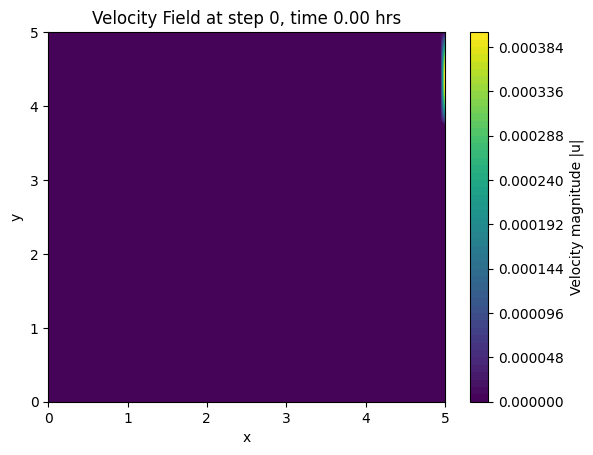

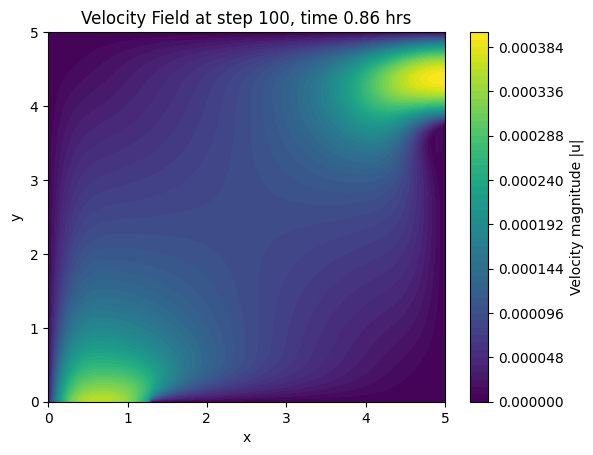

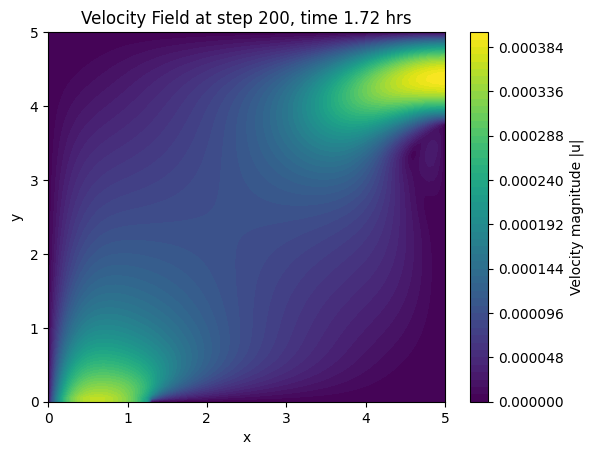

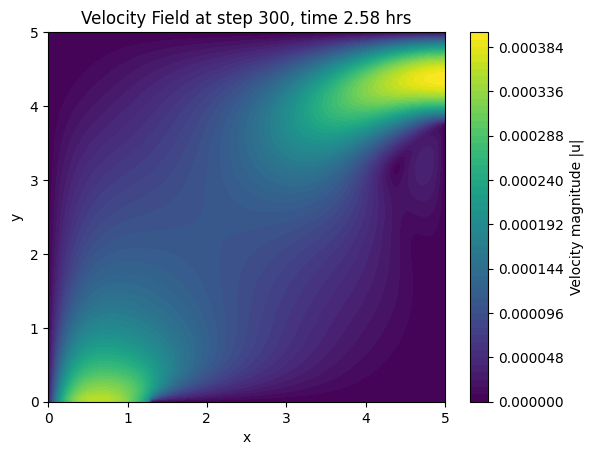

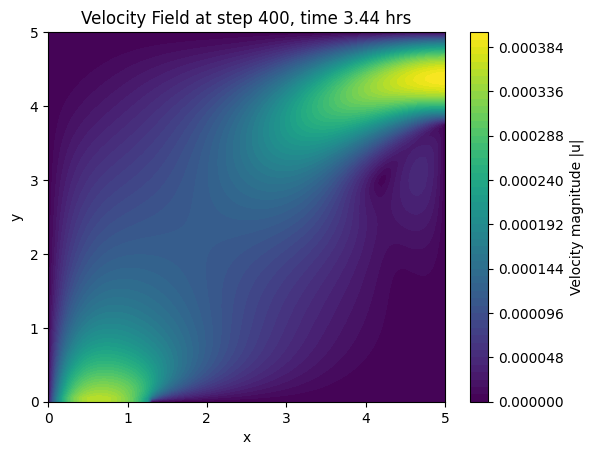

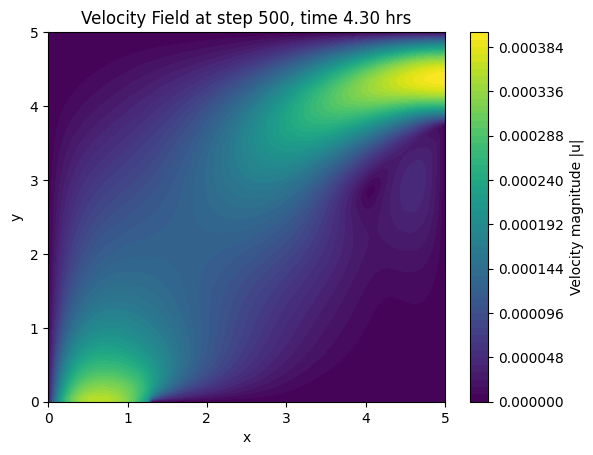

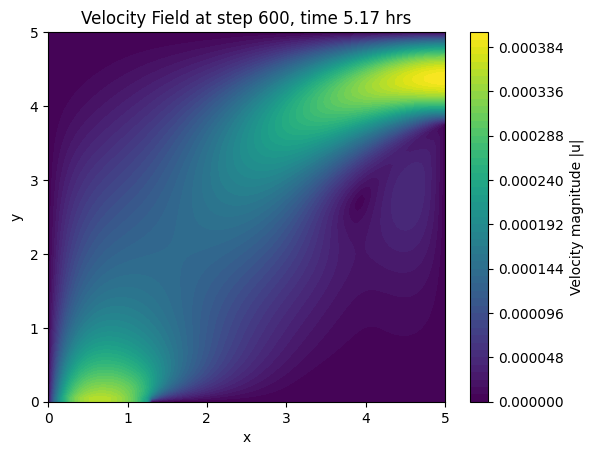

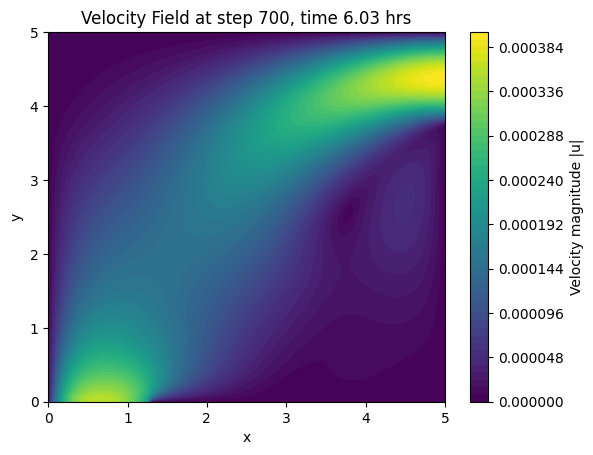

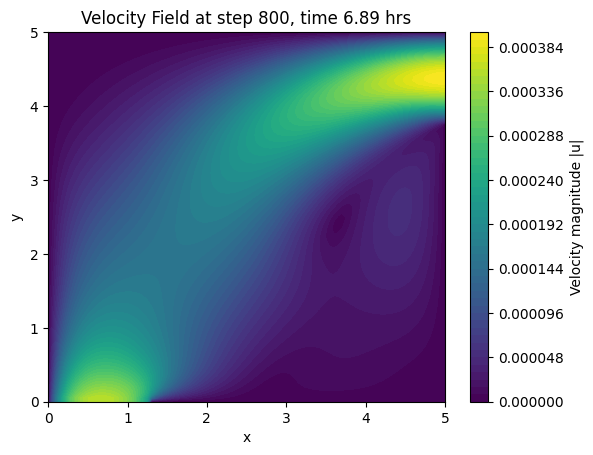

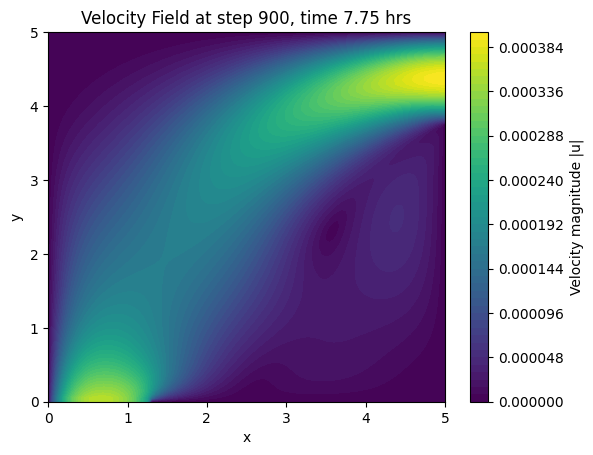

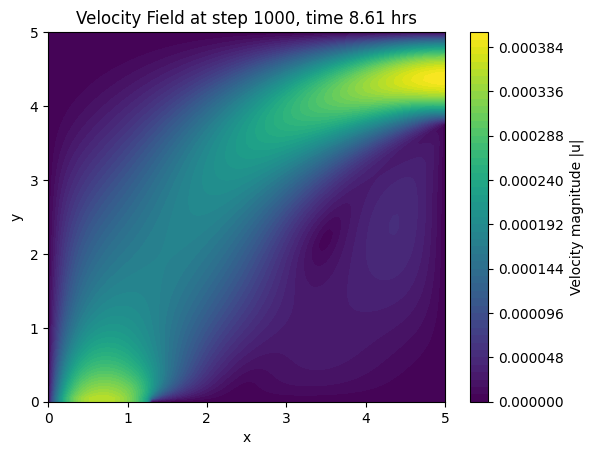

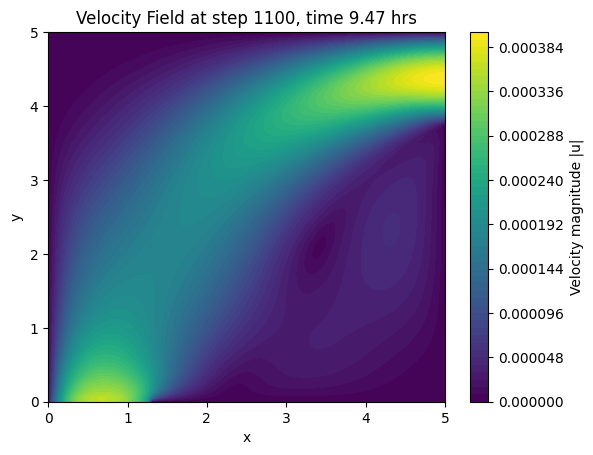

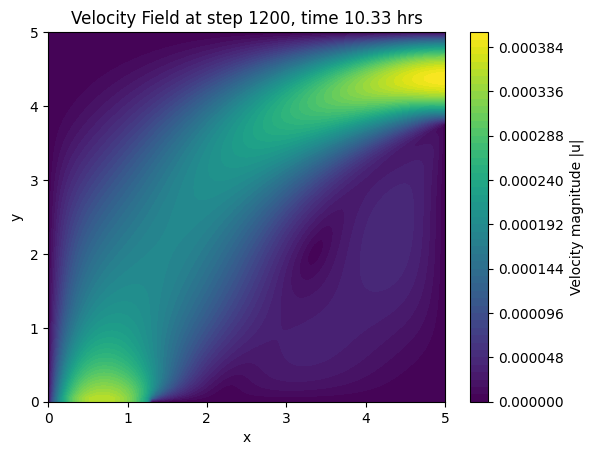

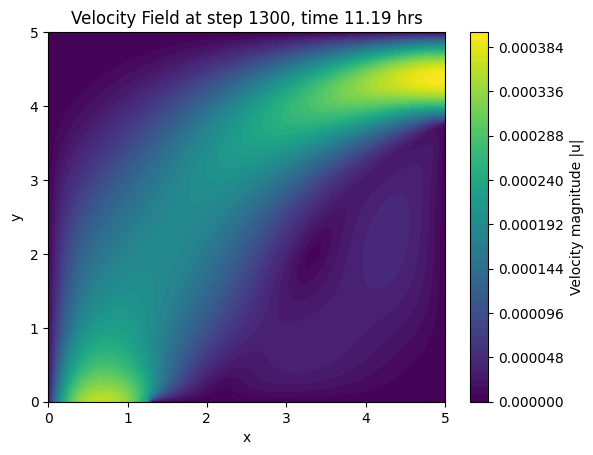

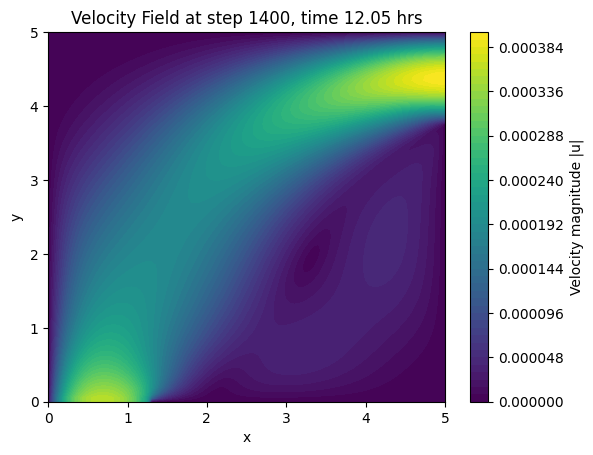

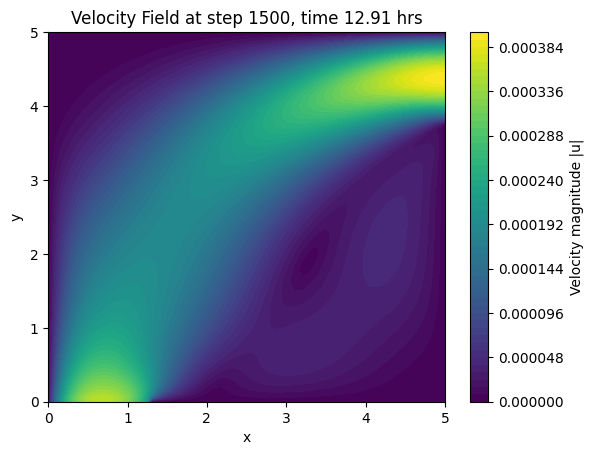

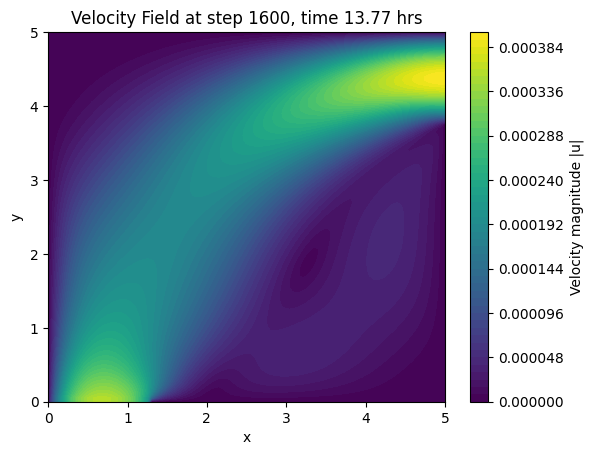

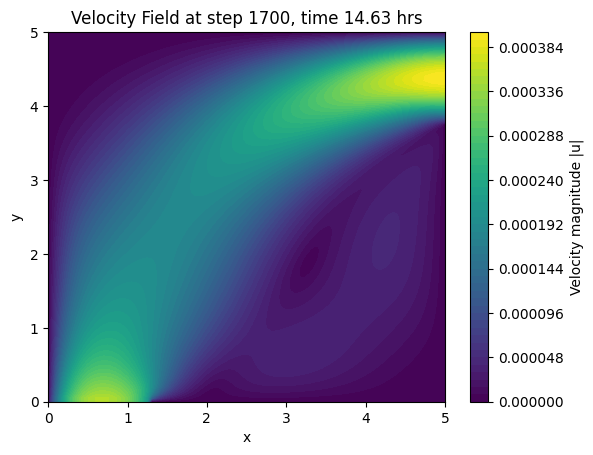

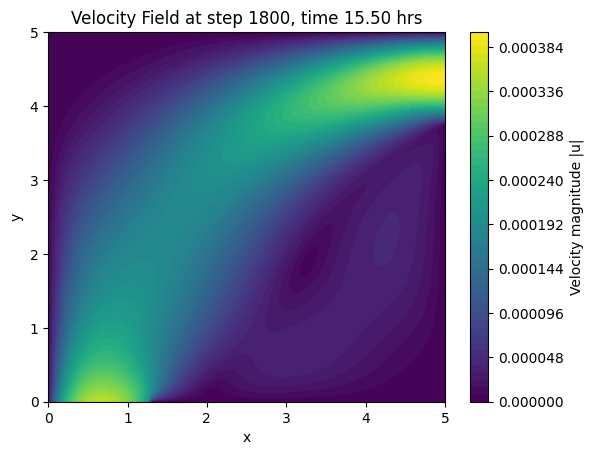

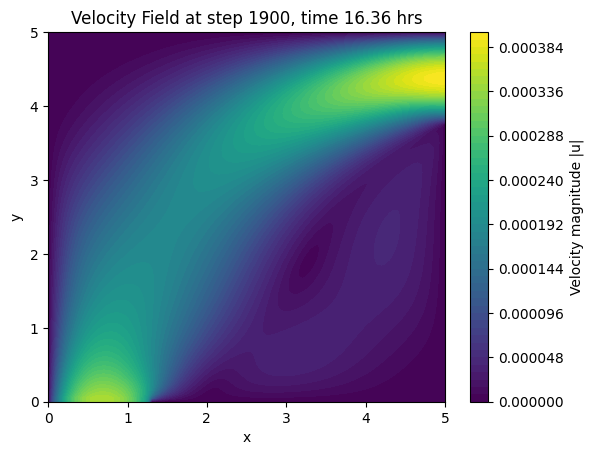

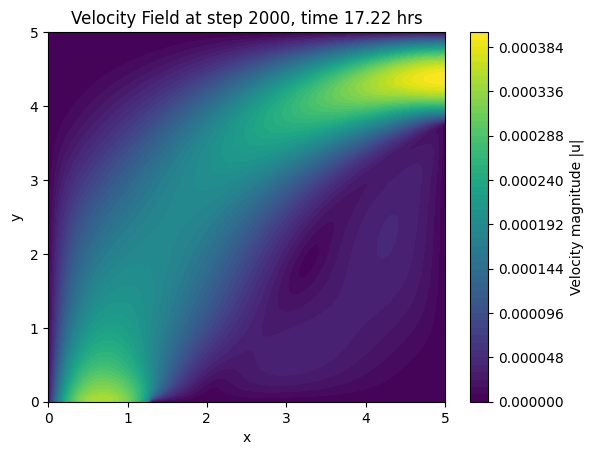

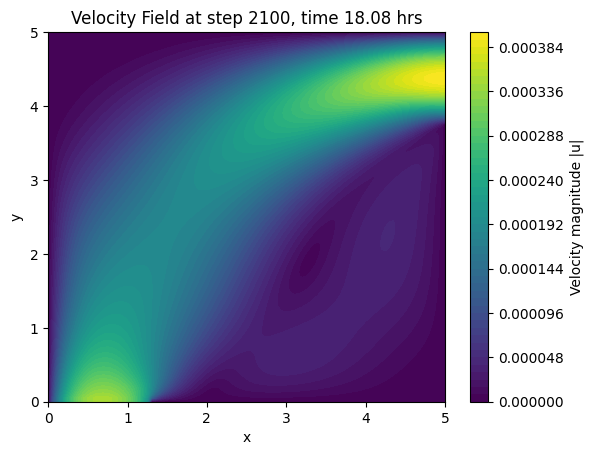

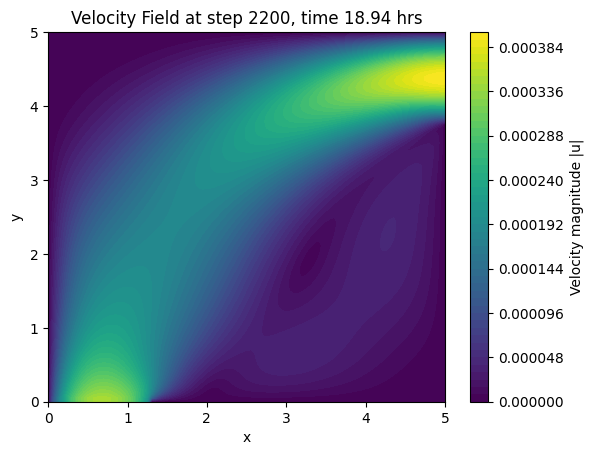

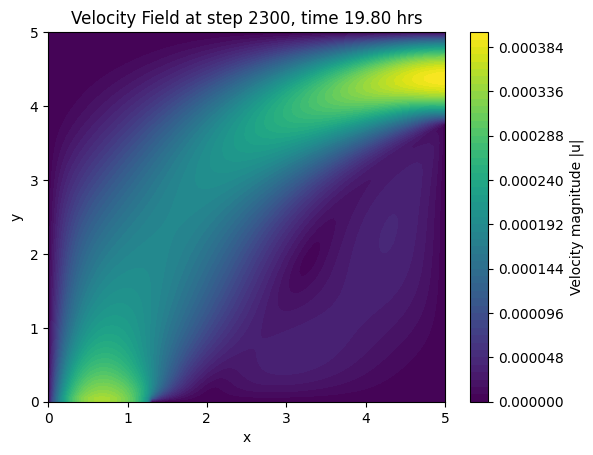

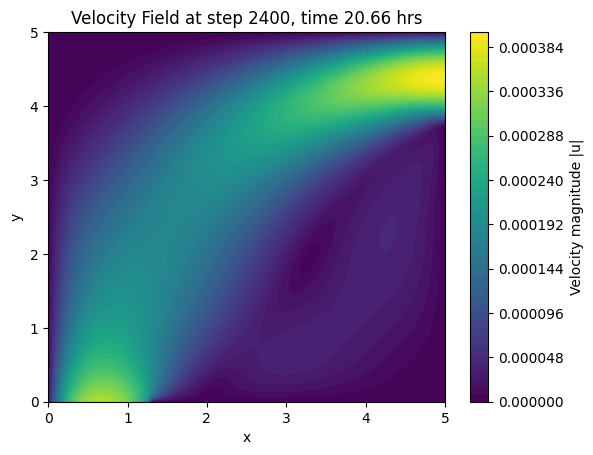

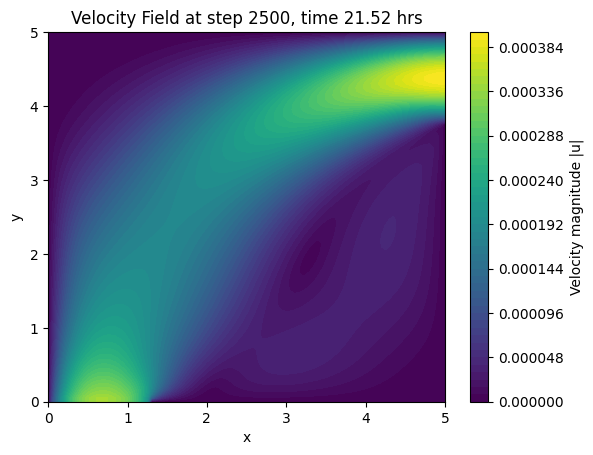

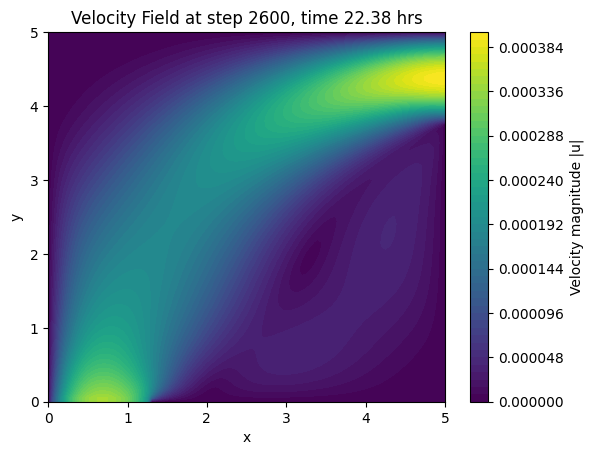

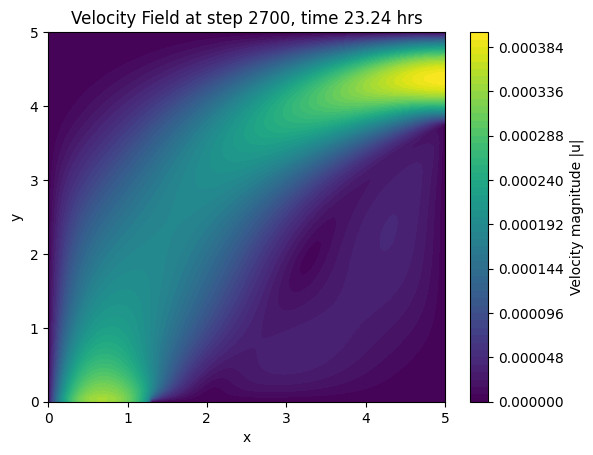

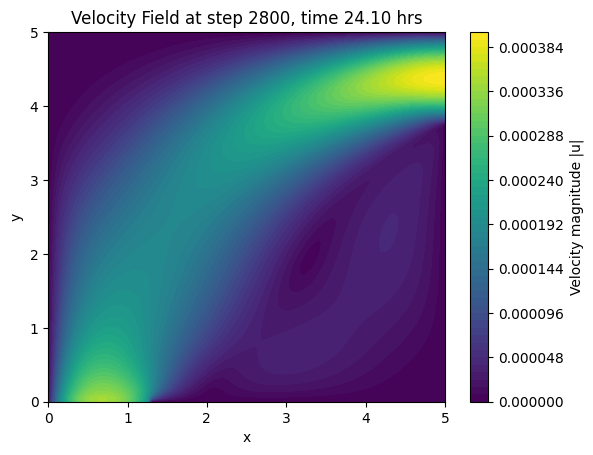

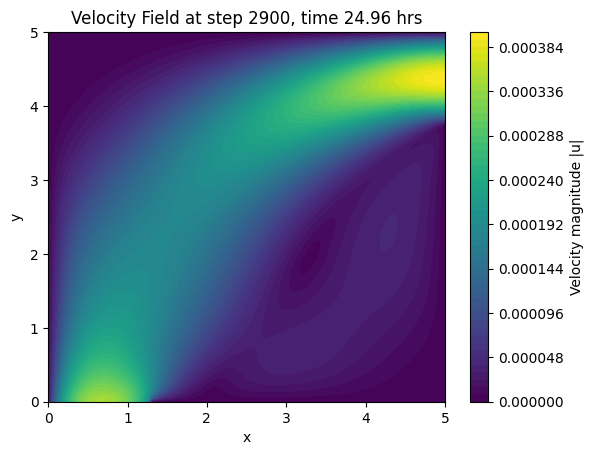

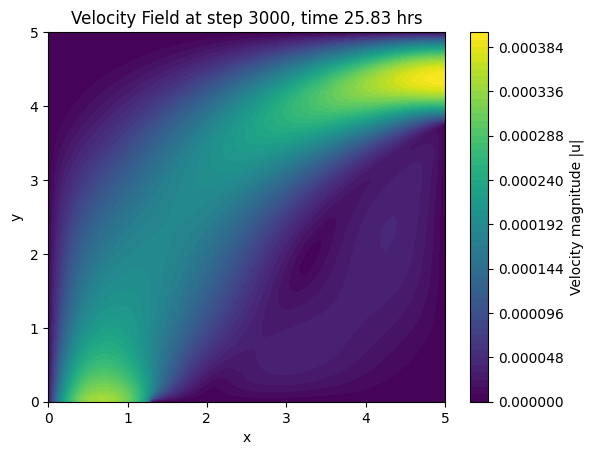

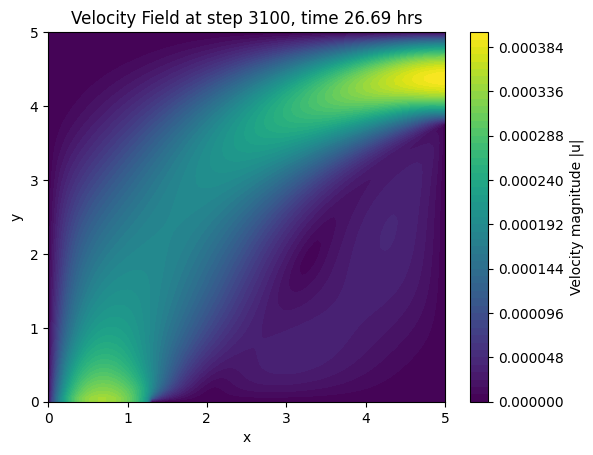

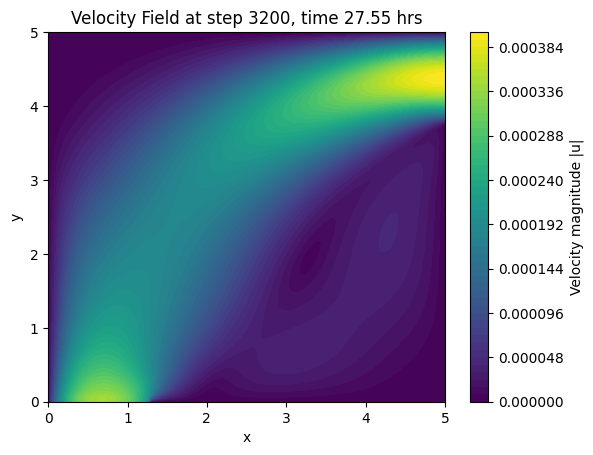

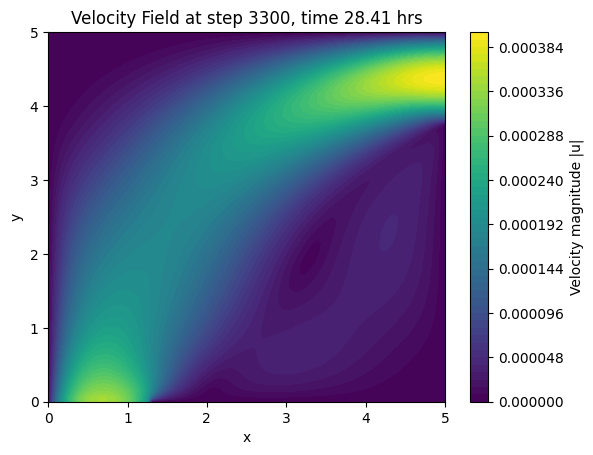

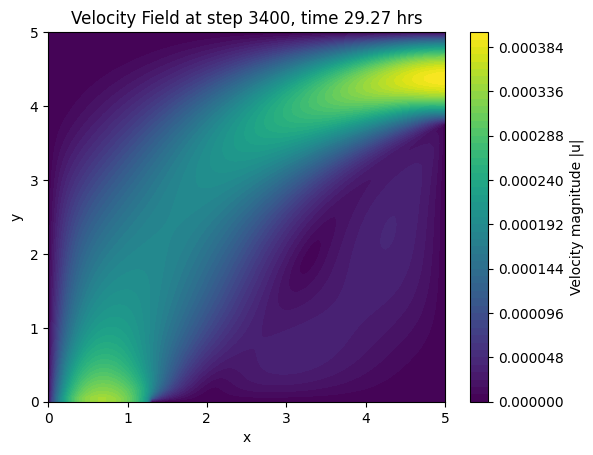

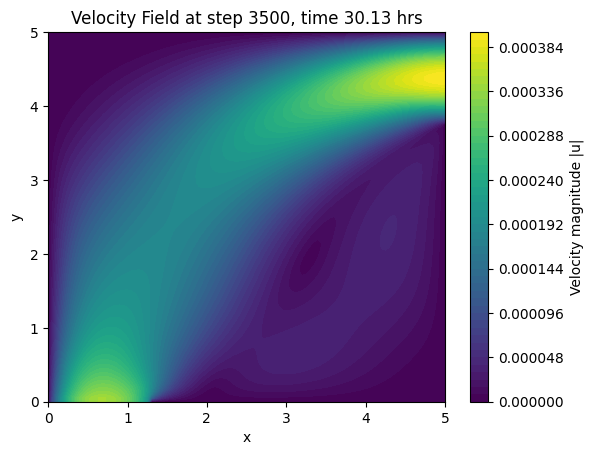

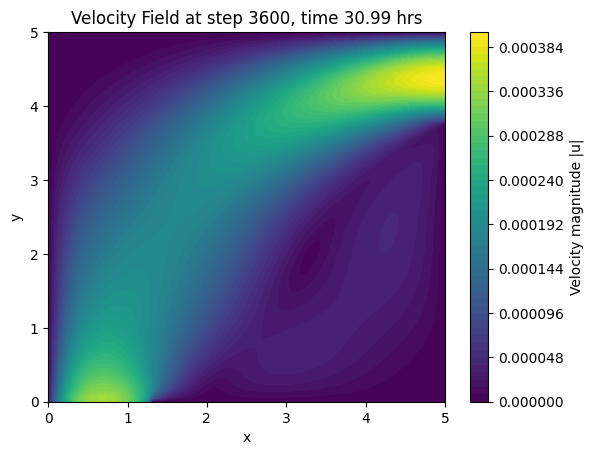

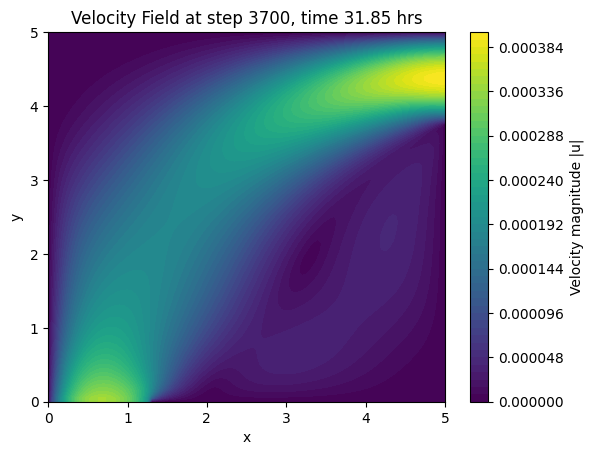

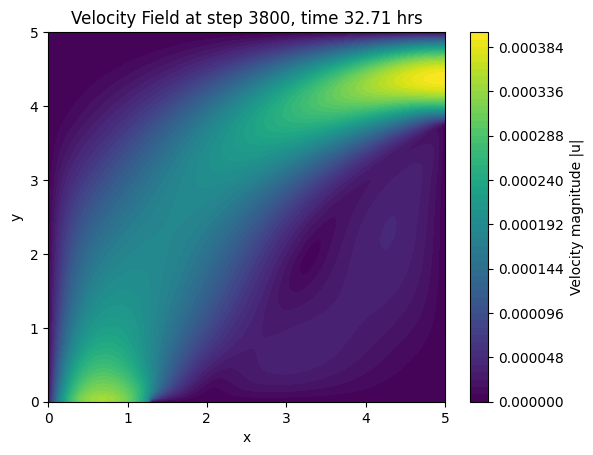

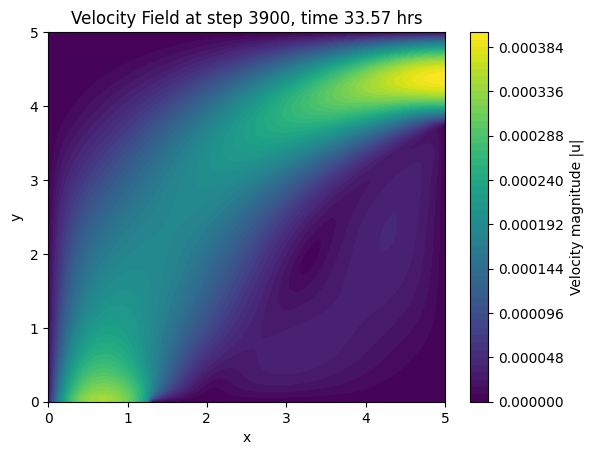

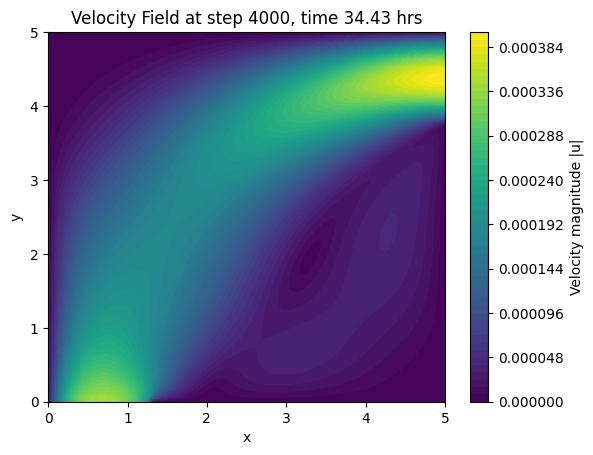

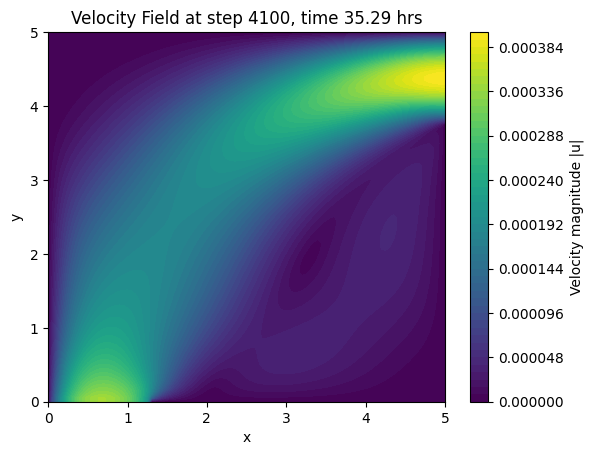

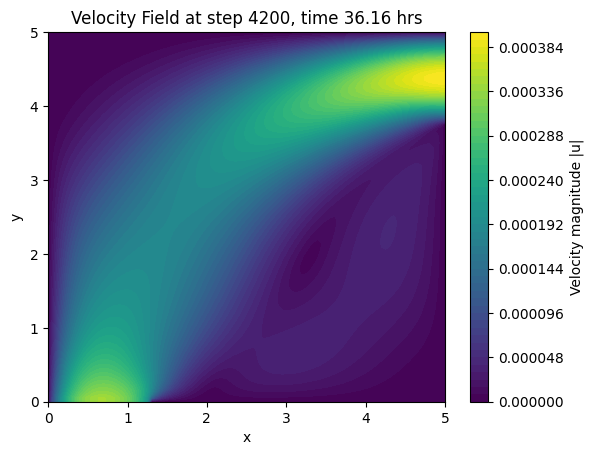

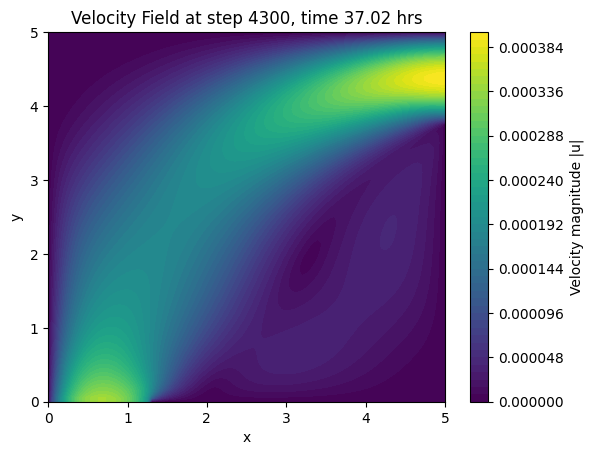

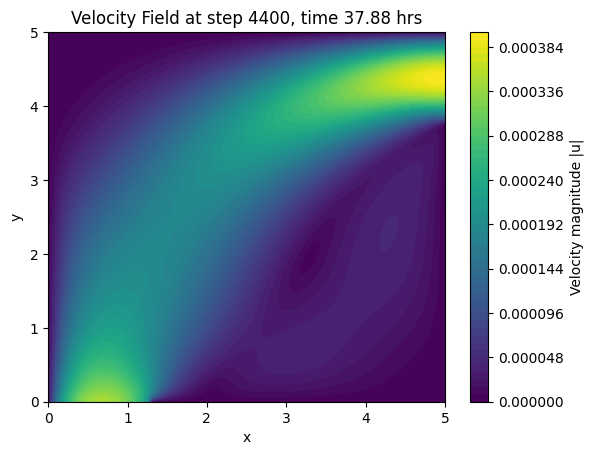

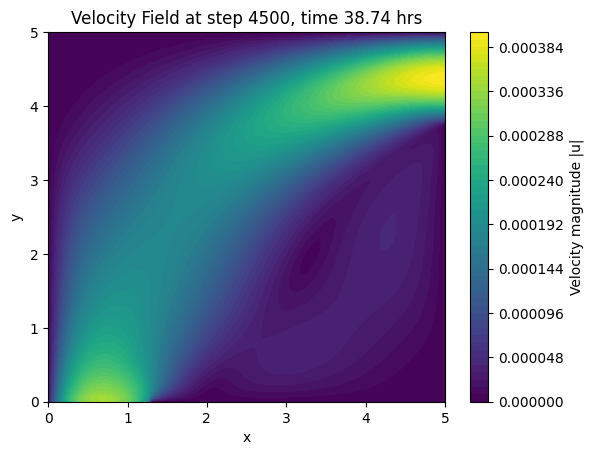

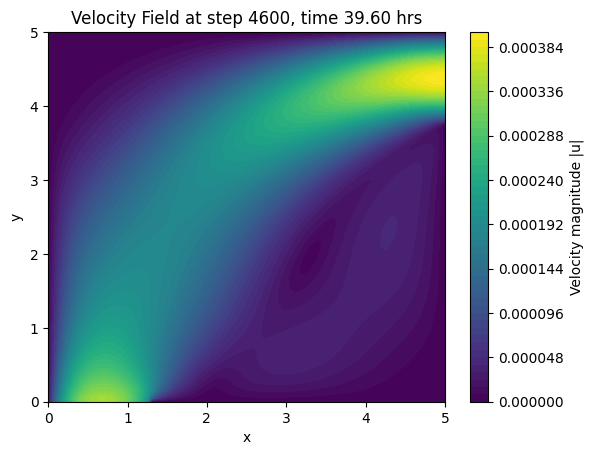

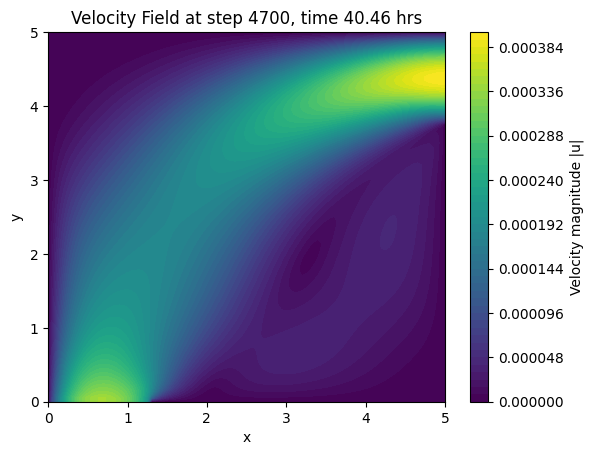

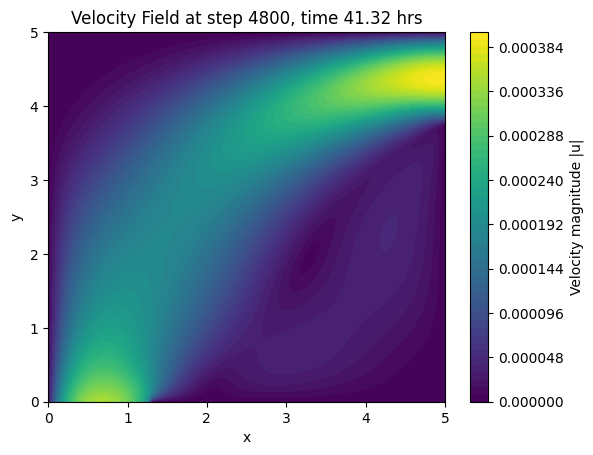

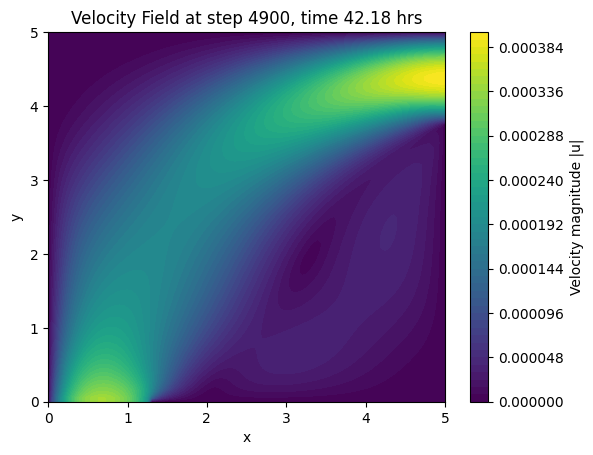

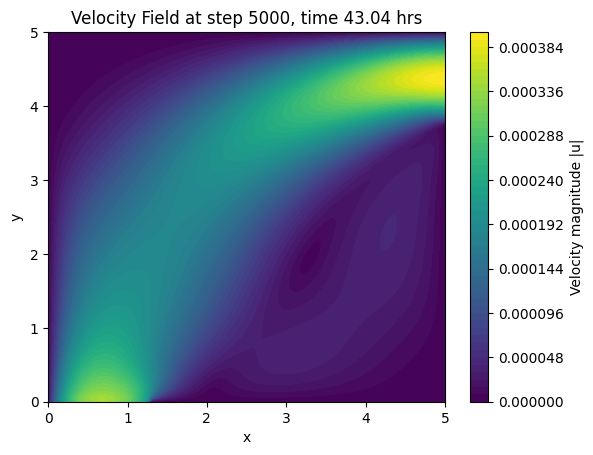

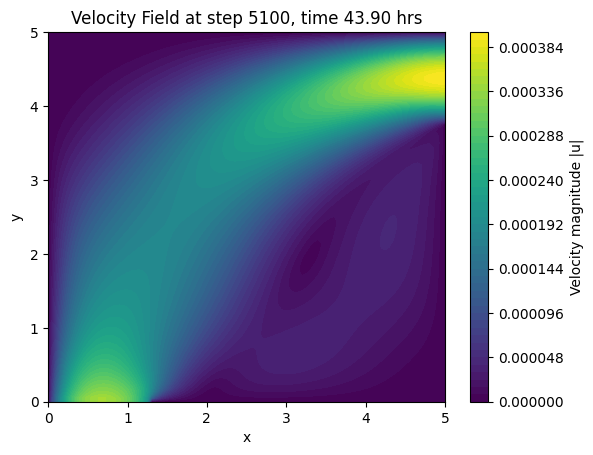

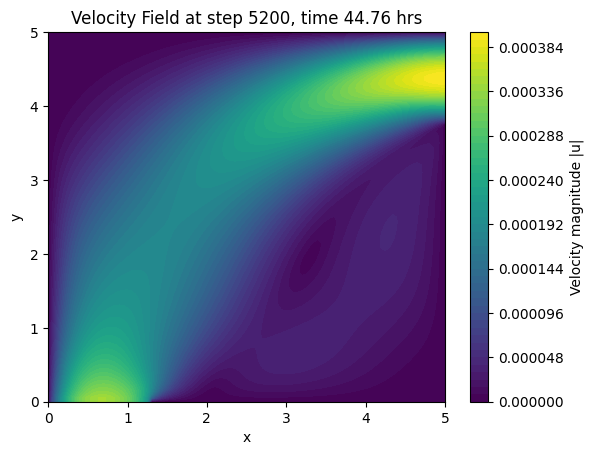

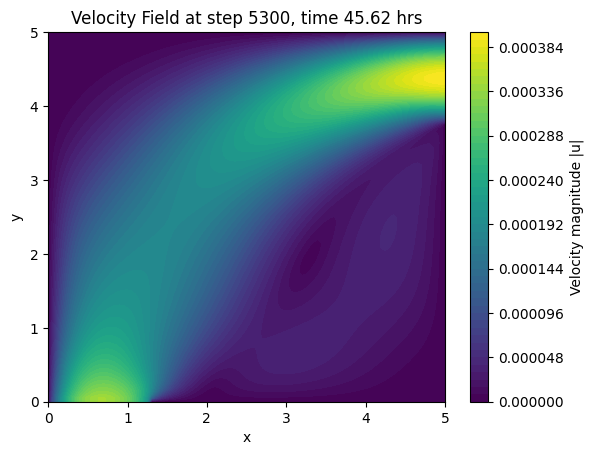

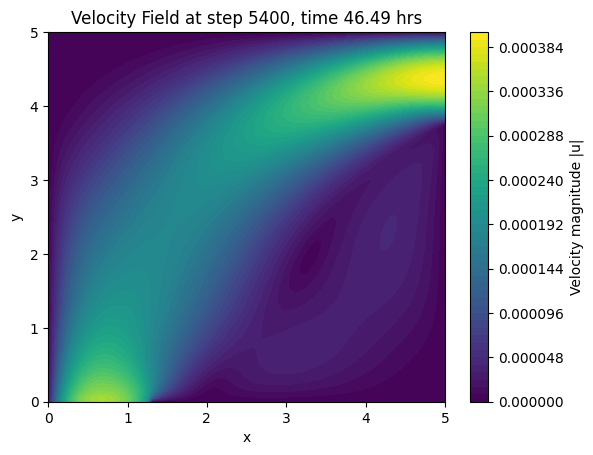

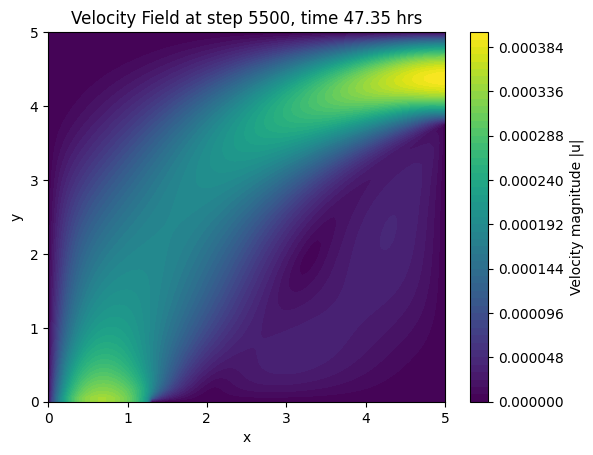

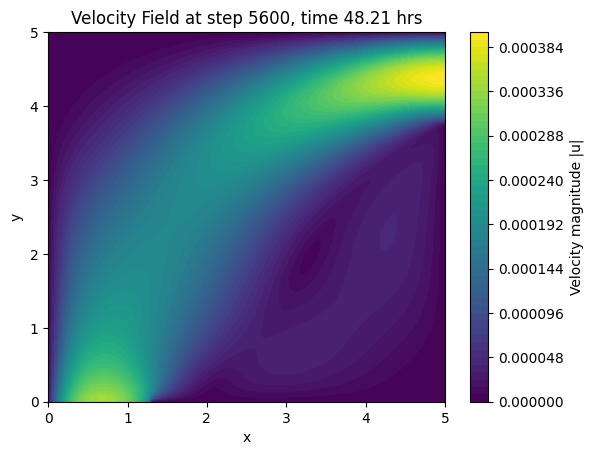

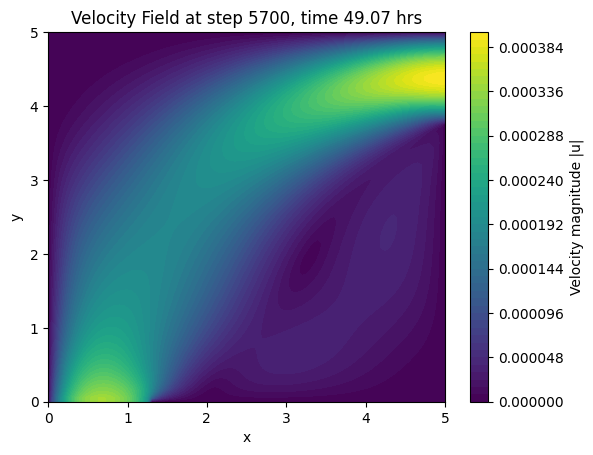

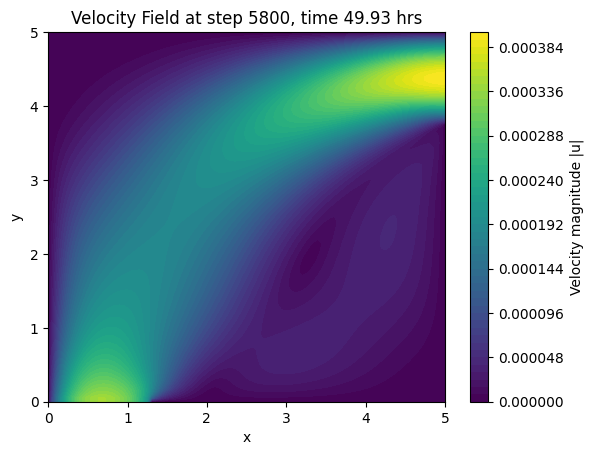

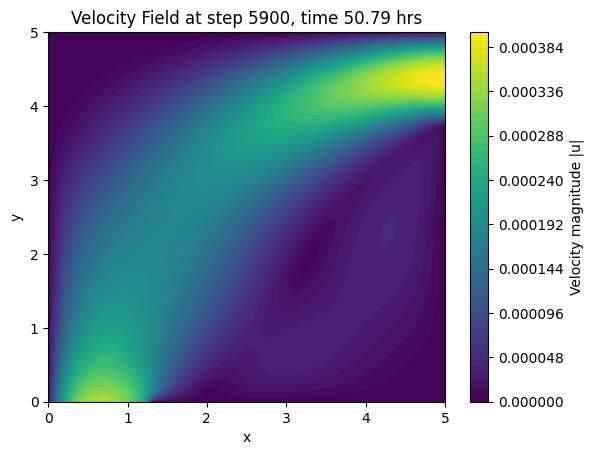

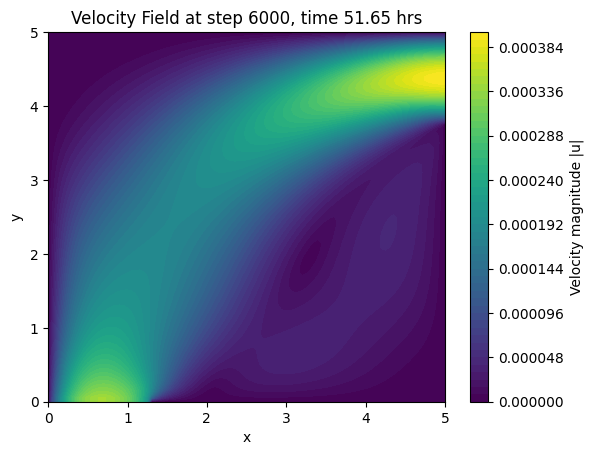

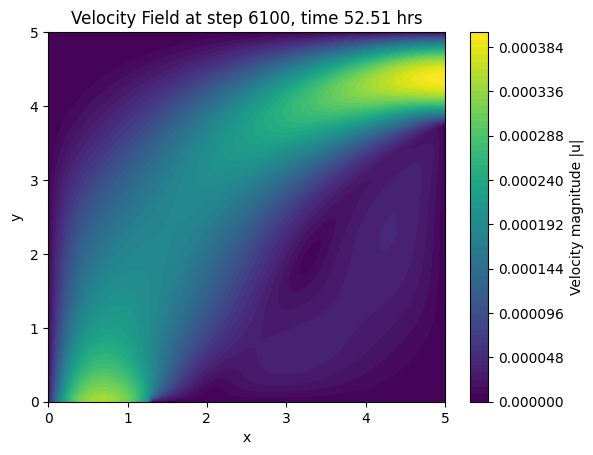

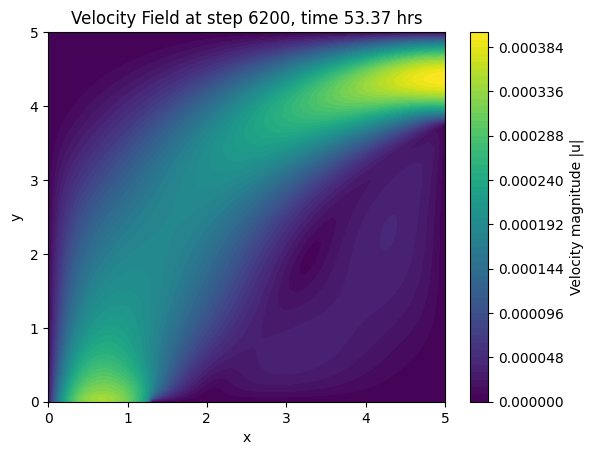

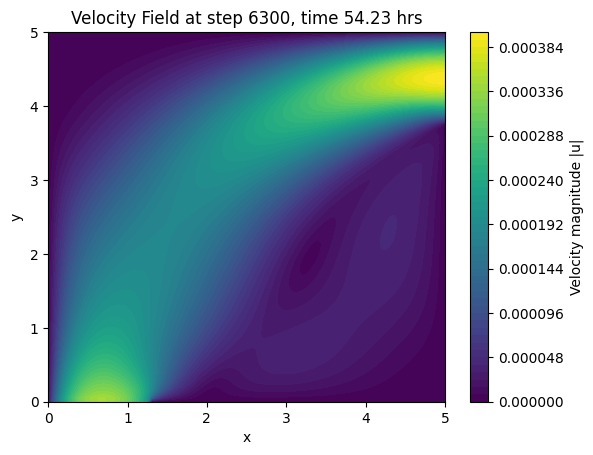

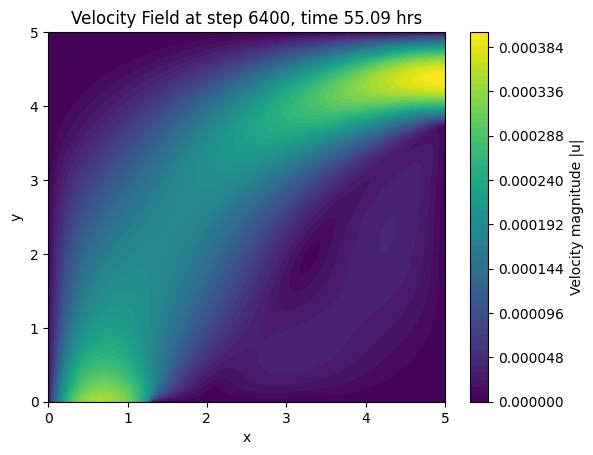

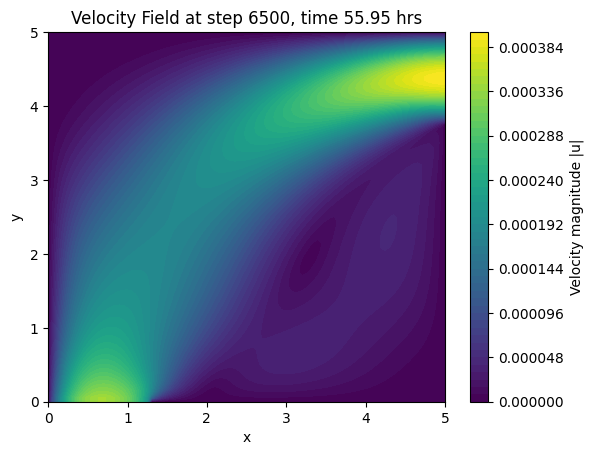

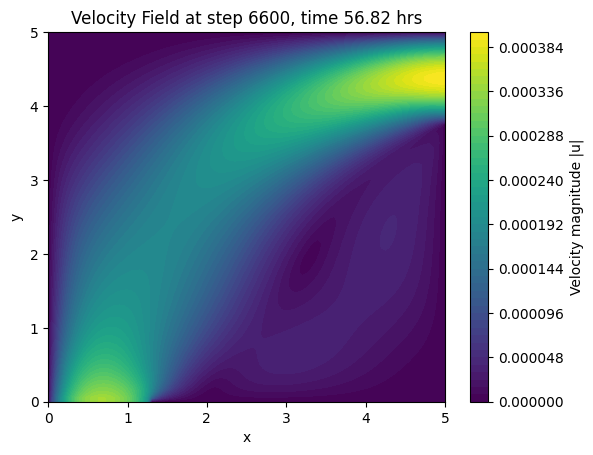

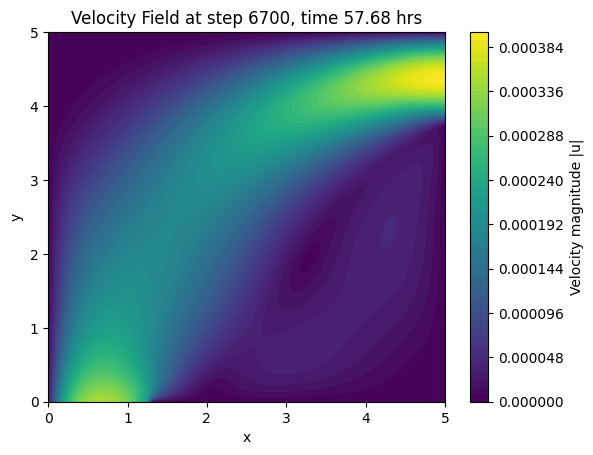

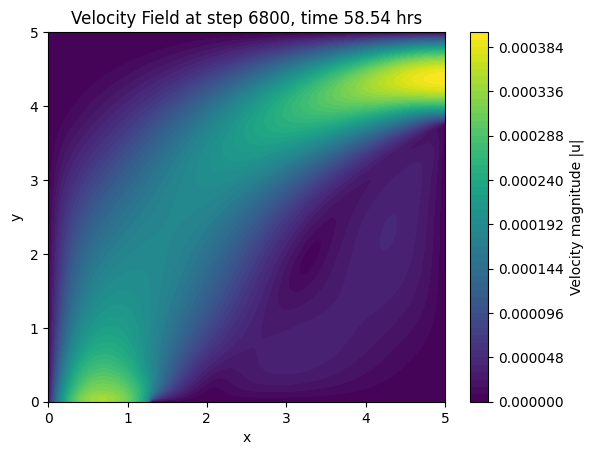

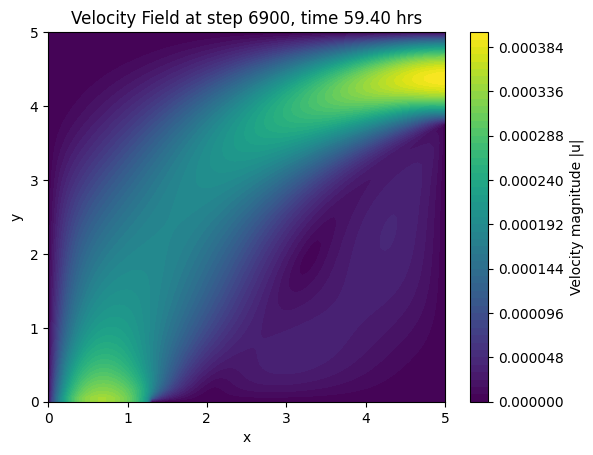

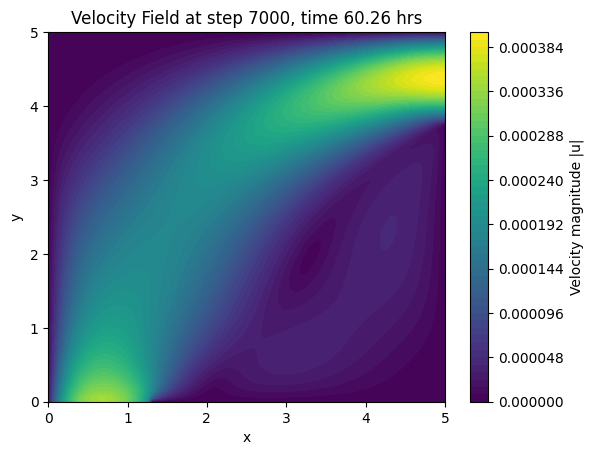

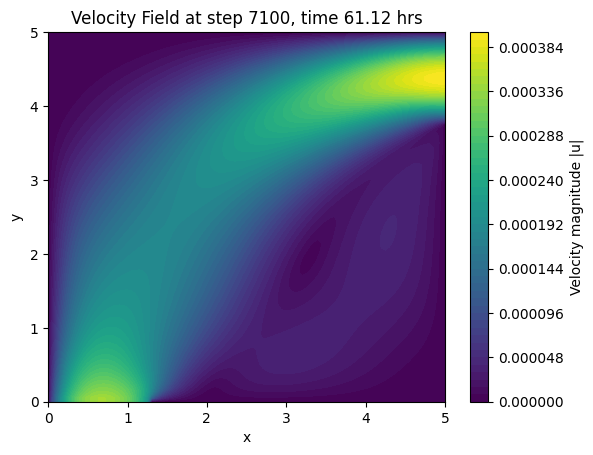

Steady state reached at step 7180, i.e. 61.80818903204423 hours
101x101 Field computed in 22.50s
Cp for Q = 3 m^3/h : 2.08781


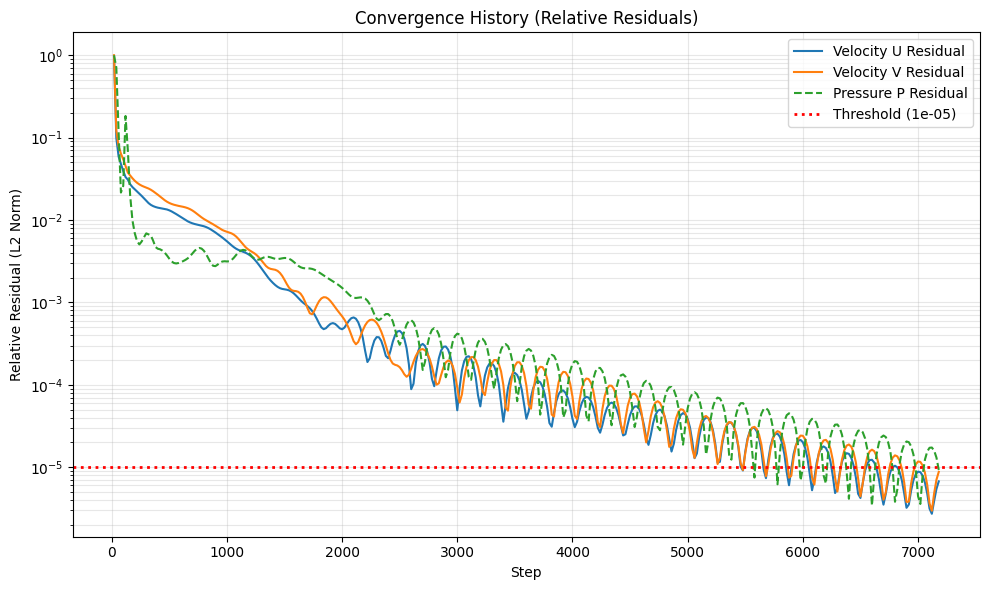

Scalar dt re-evaluated using steady u_max=3.994e-04 -> dt_scalar=3.09902e+01s


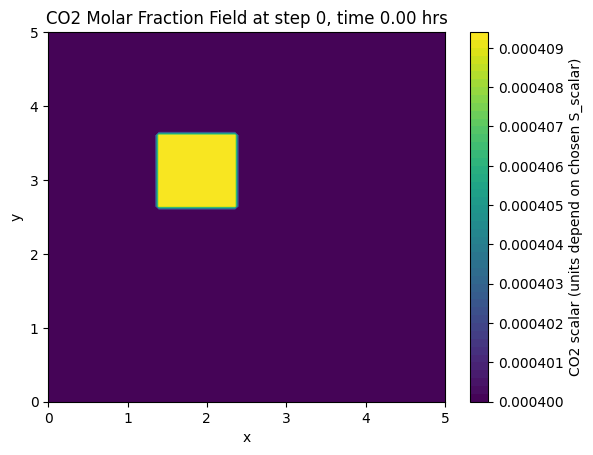

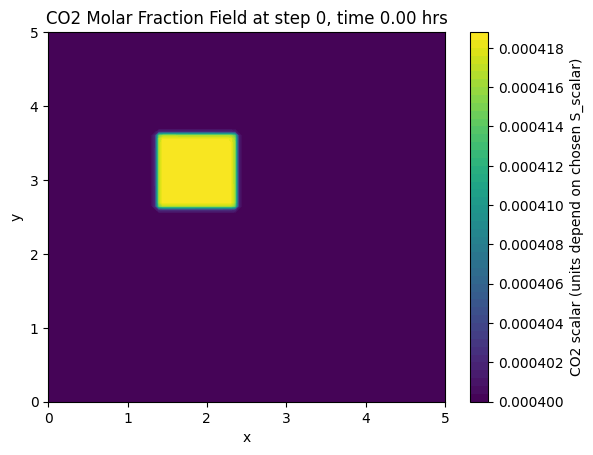

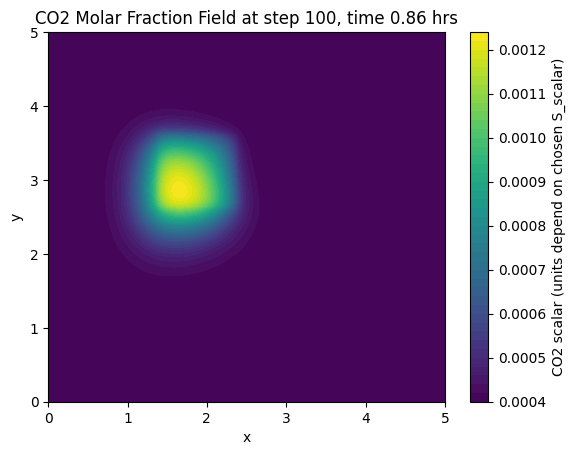

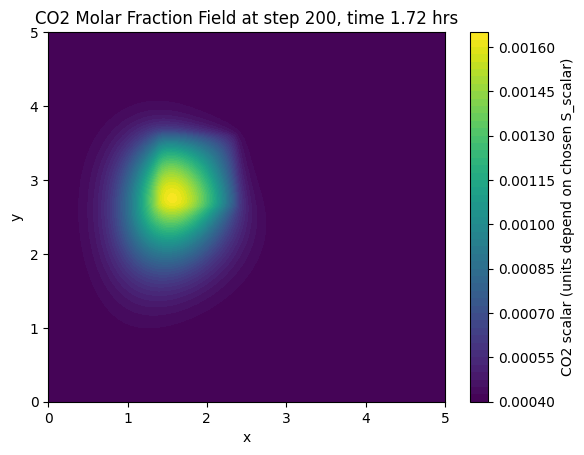

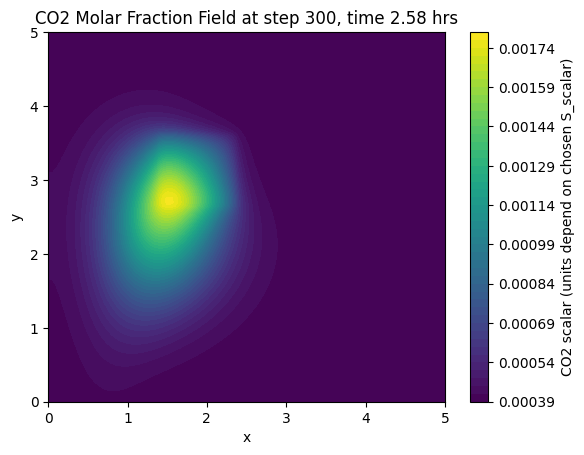

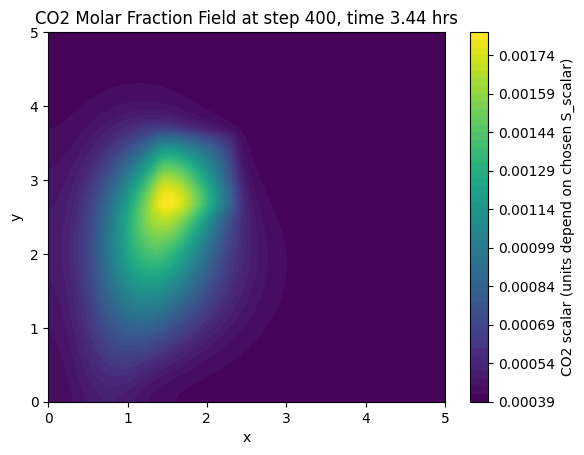

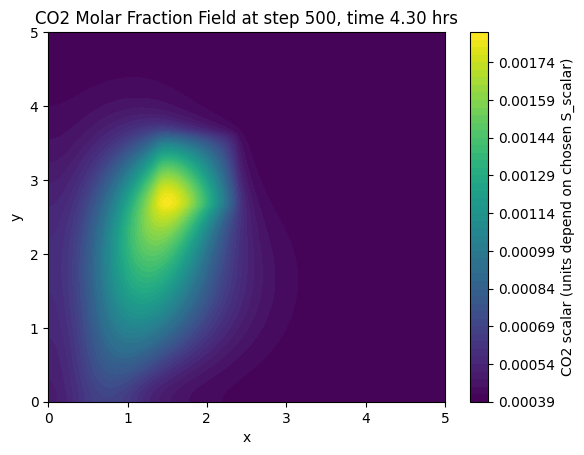

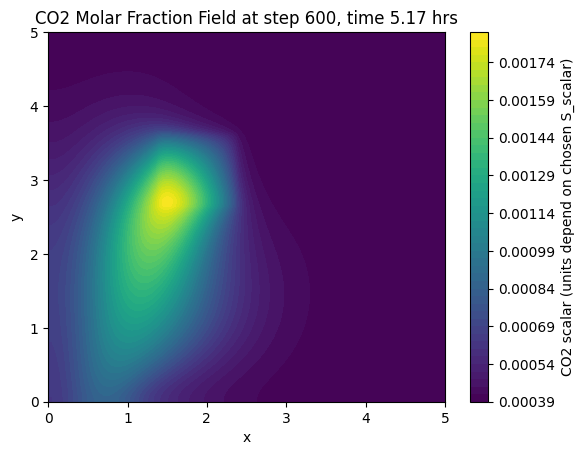

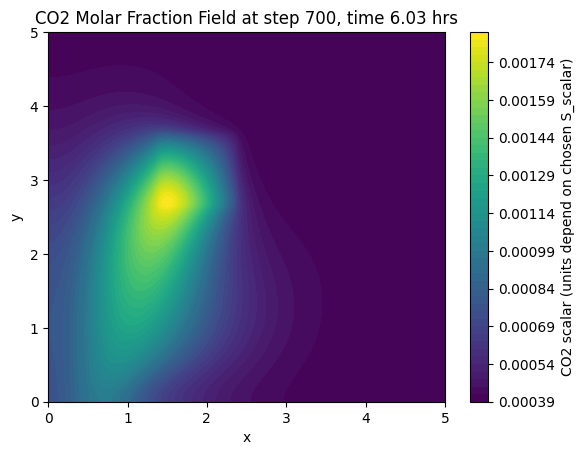

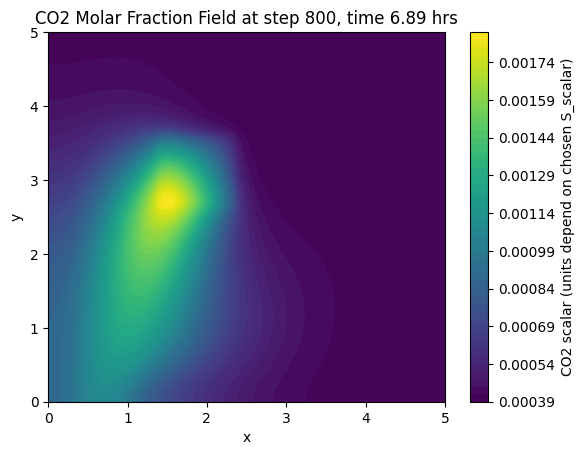

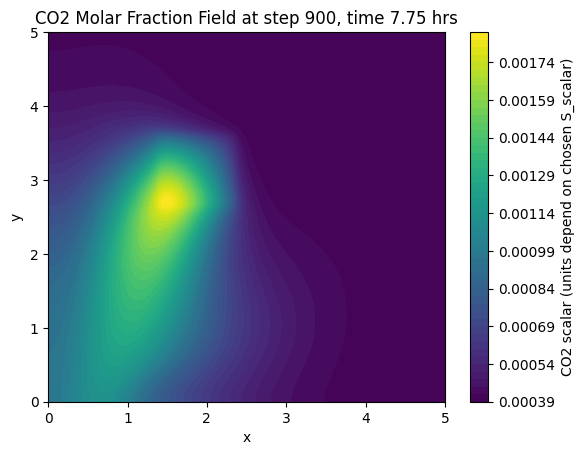

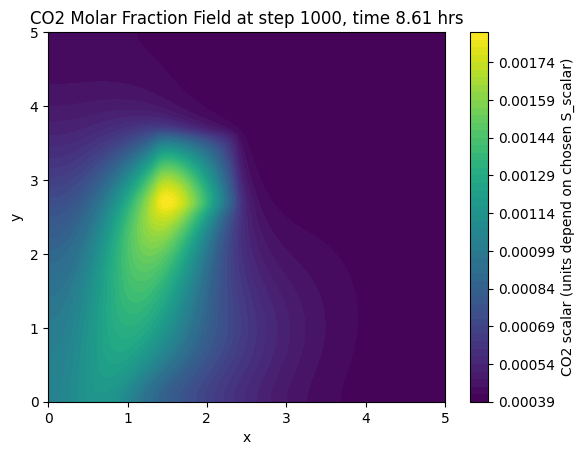

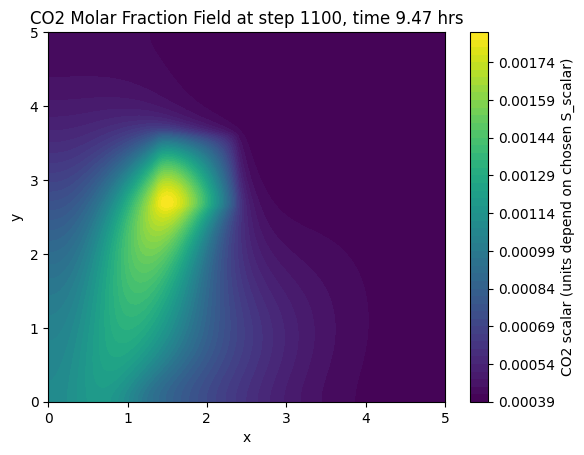

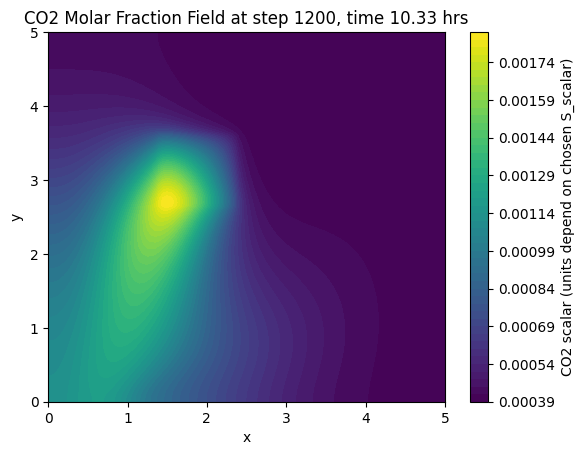

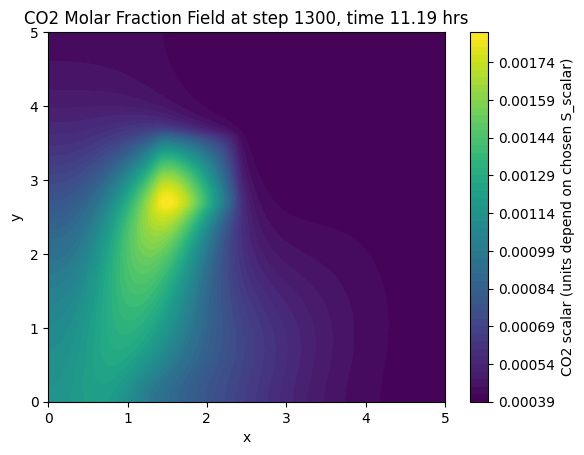

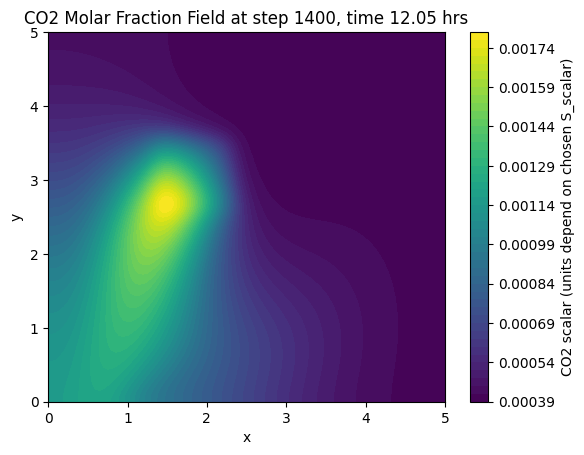

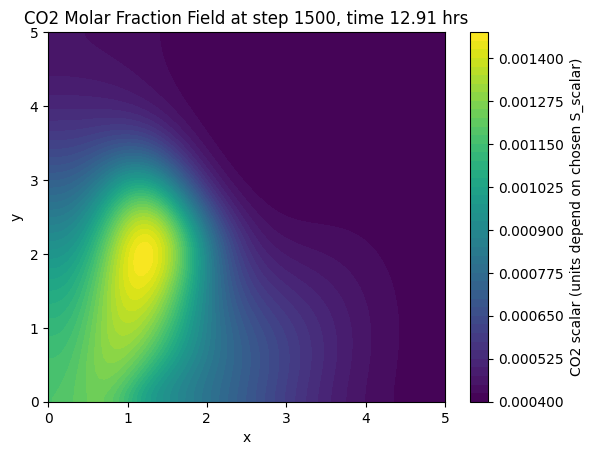

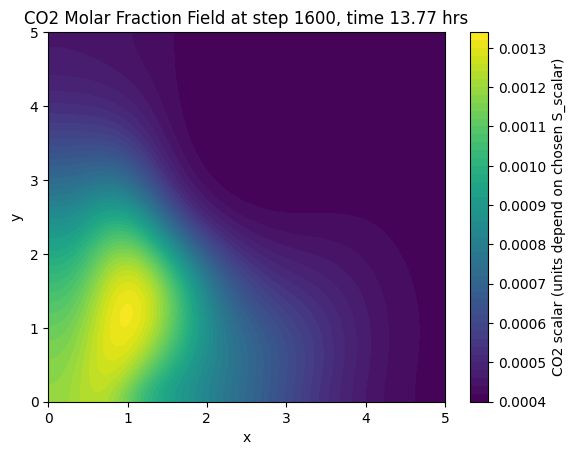

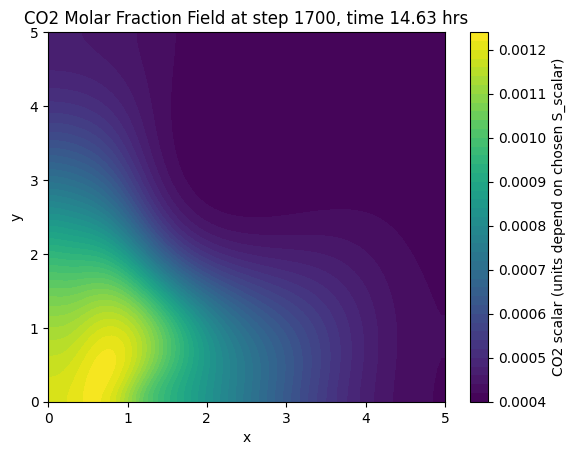

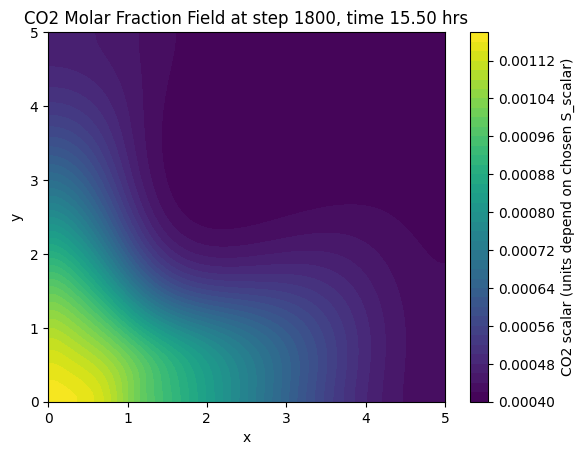

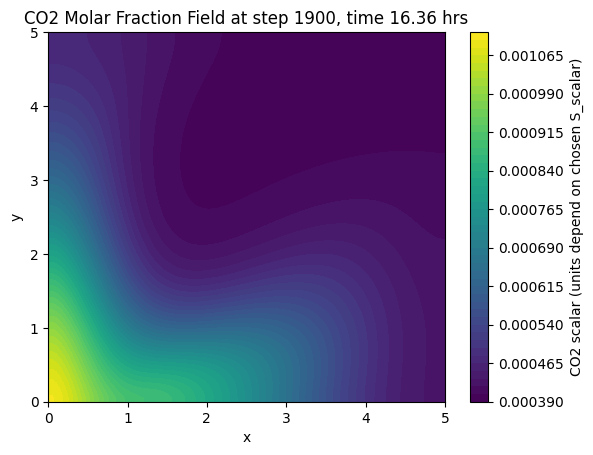

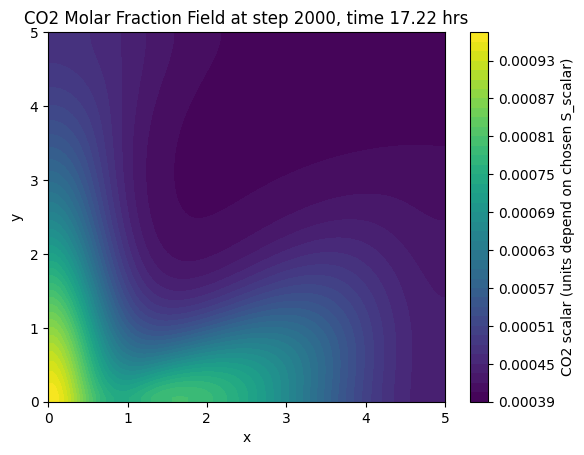

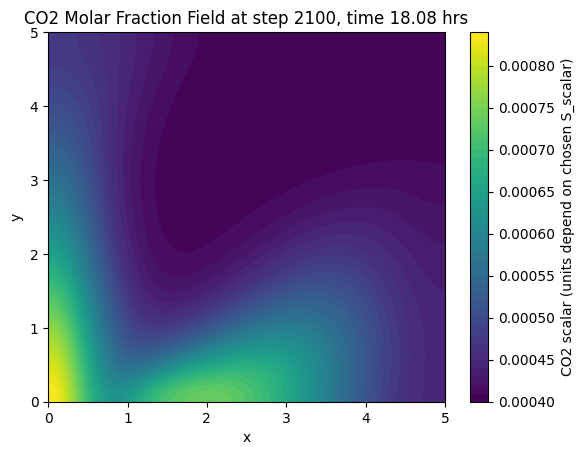

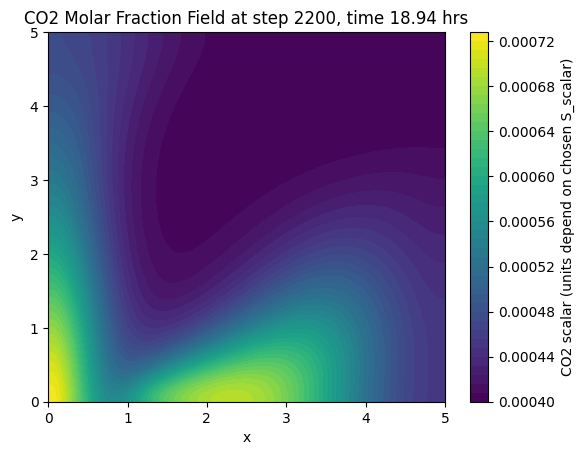

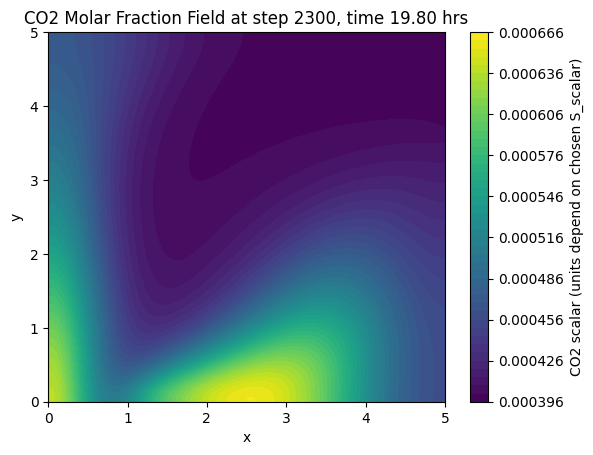

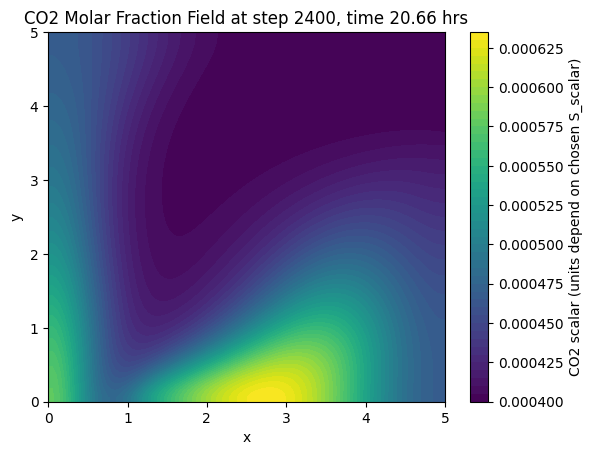

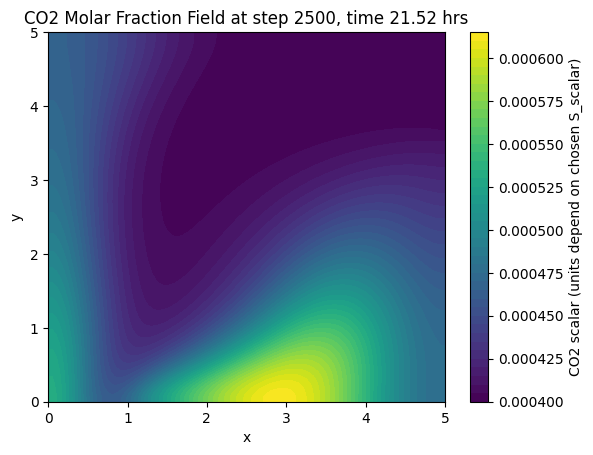

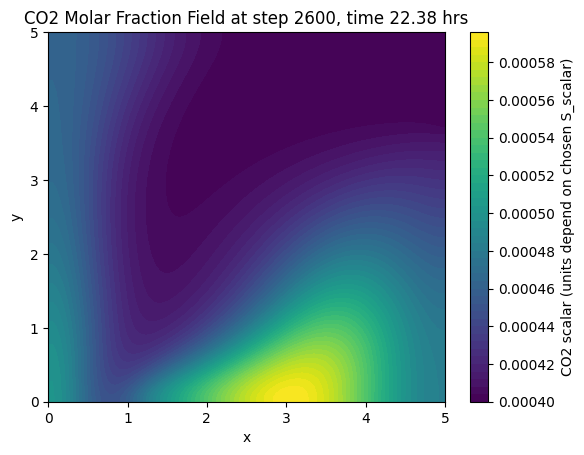

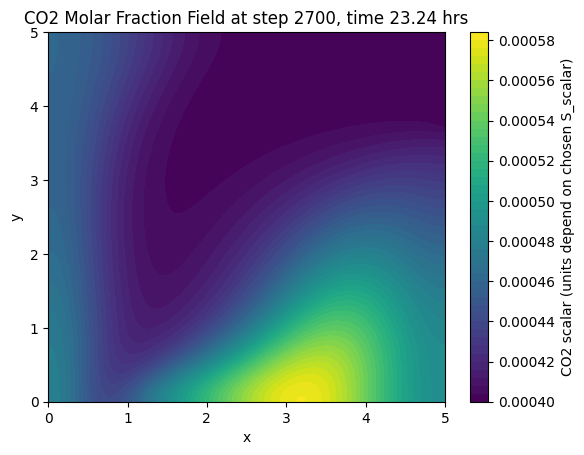

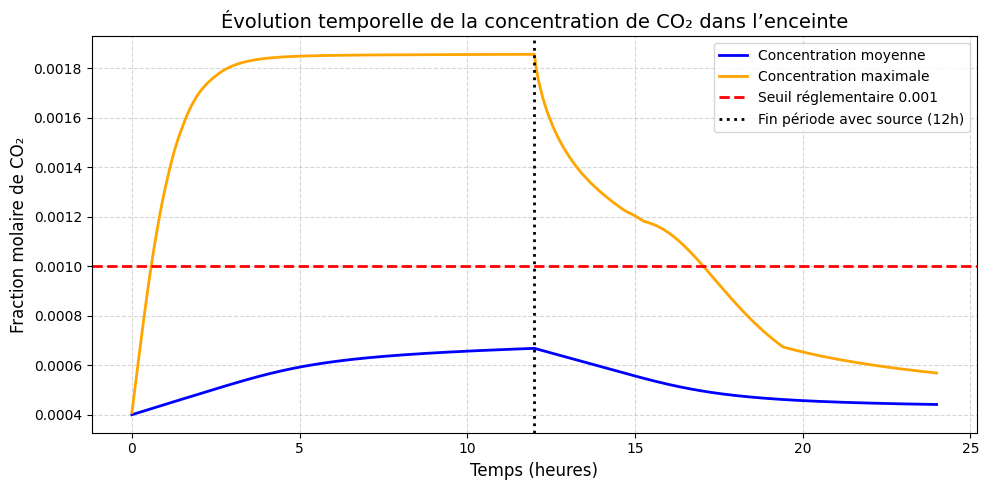

Maximum CO2 concentration reached: 0.001857 at 12.00 hours.


In [40]:

def run_scalar_simulation(u_steady, v_steady, y_inlet_index, Nx, Ny, viz_mode=None, plot_interval=100):

    start_time = time.time()
    
    # --- 1. Grid & Geometry Setup ---
    dx = L / Nx
    dy = L / Ny
    x = np.linspace(0, L, Nx)
    y = np.linspace(0, L, Ny)
    X, Y = np.meshgrid(x, y, indexing="ij")

    # Source Indices
    x_source_start = np.where(xc - 0.5*l_source <= x)[0][0]
    x_source_end = np.where(x <= xc + 0.5*l_source)[0][-1]
    y_source_start = np.where(yc - 0.5*l_source <= y)[0][0]
    y_source_end = np.where(y <= yc + 0.5*l_source)[0][-1]

    # Re-evaluate dt for scalar using steady u_max and molecular diffusion D_co2
    u_max = np.max(np.sqrt(u_steady**2 + v_steady**2))

    dt_Fo_scalar = dx**2 * Fo / D_co2
    dt_CFL_scalar = CFL * dx / u_max
    dt_scalar = min(dt_Fo_scalar, dt_CFL_scalar)

    # Start scalar 24-hr clock now
    Nt_scalar = int(t / dt_scalar)
    print(f"Scalar dt re-evaluated using steady u_max={u_max:.3e} -> dt_scalar={dt_scalar:.5e}s")

    c = INIT_CO2 * np.ones((Nx, Ny))
    S = np.zeros((Nx,Ny))
    c = apply_scalar_bcs(c, y_inlet_index, INLET_CO2)
    c += dt_scalar * compute_source_term(c, S, x_source_start, x_source_end, y_source_start, y_source_end)

    Xavg = [np.mean(c)]
    Xmax = [np.max(c)]

    if viz_mode in ('c02', 'both'):
        visualize_CO2(X, Y, c, step=0, time_hours=0.0)
        plt.pause(0.1)

    for n in range(Nt_scalar):
        # # -- Scalar Transport --
        c = advect_scalar(c, u_steady, v_steady, dx, dy, dt_scalar)
        c = diffuse_scalar(c, dx, dy, dt_scalar, D_co2)
        
        # Source Term (Inline for speed)
        if n*dt_scalar < time_interval/2 * 3600:
            c += dt_scalar * compute_source_term(c, S, x_source_start, x_source_end, y_source_start, y_source_end)

        c = apply_scalar_bcs(c, y_inlet_index, INLET_CO2)

        Xavg.append(np.mean(c))
        Xmax.append(np.max(c))

        if viz_mode in ('c02', 'both') and n % plot_interval == 0:
            visualize_CO2(X, Y, c, step=n, time_hours=n*dt_scalar/3600)
            plt.pause(0.1)

    elapsed = time.time() - start_time
     #print(f"{Nx}x{Ny} Concentration field computed in {elapsed:.2f}s")

    return dt_scalar, Xavg, Xmax


if __name__ == "__main__":
    Nx, Ny = 101, 101
    Q_M3H = 3  # Inlet flow rate in m^3/h
    field_tol_value = 1e-5 # convergence tolerance for velocity and pressure fields
    viz_mode = 'both'  # Options: None, 'field', 'c02', 'both'

    u_steady, v_steady, y_inlet_index, history_res, cp = run_field_simulation(Nx, Ny, Q_M3H, field_tol_value, viz_mode=viz_mode)
    print(f"Cp for Q = {Q_M3H} m^3/h : {cp:.5f}")
    plot_residual_history(history_res, tol_val=field_tol_value)    # Plot the Residuals immediately to check quality

    dt_scalar, Xavg, Xmax = run_scalar_simulation(u_steady, v_steady, y_inlet_index, Nx, Ny, viz_mode=viz_mode)
    plt.show()
        
    max_X = np.max(Xmax)
    idx_max = np.argmax(Xmax)

    # Plot CO2 time evolution
    plot_CO2_time_evolution(Xavg, Xmax, dt_scalar)
    print(f"Maximum CO2 concentration reached: {max_X:.6f} at {idx_max * dt_scalar / 3600:.2f} hours.")

    # # MESH ANALYSIS - COMMENT OUT TO RUN
    # # 1. Define Grids to test (Coarse -> Fine)
    # # Using smaller numbers here for the demo to run fast.
    # # For real analysis, use [50, 100, 150] or [50, 75, 112] (ratio 1.5)
    # test_meshes = [21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281] 
    
    # results_vel = []
    # results_co2 = []
    
    # # 2. Run the Sweep
    # for N in test_meshes:
    #     u_val, _, _, Xmax = run_simulation(N, N)
    #     results_vel.append(u_val)
    #     results_co2.append(np.max(Xmax))
        
    # # 3. Plot the results
    # plot_mesh_convergence(test_meshes, results_vel, results_co2)